In [6]:
import requests
from IPython.core.display import HTML
from torch import optim
from trainers import PyTorchTrainer
from networks import *
from torchvision import transforms
from cnn_util import *
from fashionmnist_utils.mnist_reader import load_mnist
from models import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from trainers import PyTorchTrainer
from torchvision import transforms
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from networks import CNNBasic
from cnn_util import evaluate_overall_metrics, evaluate
from trainers import PyTorchTrainer


# Global flag to skip training
SKIP_TRAINING = True


# Notes

## Batch size
Batch size = 1: Model updates after 1 data point. (1024 steps for 1024 data points)
Batch size = 512: Model updates after 512 data points. (2 steps for 1024 data points)
Batch size = 1024: Model updates after all 1024 data points. (1 step for 1024 data points)

# Neural network architectures
This exercise focuses on the classification of the FashionMNIST dataset using two types of neural network architectures: the Multi-Layer Perceptron (MLP) and the Convolutional Neural Network (CNN). The performance of these models will be assessed using the evaluation metrics introduced in earlier exercises.

<article class="message">
    <div class="message-body">
        <strong>List of individual tasks</strong>
        <ul style="list-style: none;">
            <li>
            <a href="#MLP1">Task 1: Training basic MLP</a>
            </li>
            <li>
            <a href="#MLP3">Task 2: Evaluation</a>
            </li>
            <li>
            <a href="#MLP33">Task 3: Training basic MLP modifying hyperparame…</a>
            </li>
            <li>
            <a href="#MLP33333">Task 4: Comparison</a>
            </li>
            <li>
            <a href="#CNN1">Task 5: CNN architecture</a>
            </li>
            <li>
            <a href="#CNN11">Task 6: Training a basic CNN</a>
            </li>
            <li>
            <a href="#CNN21">Task 7: Evaluation</a>
            </li>
            <li>
            <a href="#CNN211">Task 8: Training a basic CNN modifying hyperpara…</a>
            </li>
            <li>
            <a href="#CNN3">Task 9: Evaluation</a>
            </li>
            <li>
            <a href="#CNN311">Task 10: Evaluation</a>
            </li>
            <li>
            <a href="#modifications">Task 11: Adding a hidden layer</a>
            </li>
            <li>
            <a href="#CNN20101">Task 12: Compare performance</a>
            </li>
            <li>
            <a href="#CNN_mod">Task 13: Compare architectures</a>
            </li>
            <li>
            <a href="#CNN233">Task 14: Compare performance</a>
            </li>
            <li>
            <a href="#CNN2123">Task 15: Update architecture</a>
            </li>
            <li>
            <a href="#modifications3">Task 16: Adding a convolutional layer</a>
            </li>
            <li>
            <a href="#CNN003">Task 17: Compare architectures</a>
            </li>
            <li>
            <a href="#modifications4">Task 18: Compare architectures</a>
            </li>
            <li>
            <a href="#additional">Task 19: Additional improvements</a>
            </li>
        </ul>
    </div>
</article>


**Time sink warning**
This exercise examines the impact of network architectures and hyperparameters on training and performance. **Notice getting optimal results can become a time sink. Make well-argued choices as endless options and combinations are available.** Focus on informed decisions given the vast number of options available. Most of the code is provided requiring only modifications to hyperparameter settings and network architecture. This setup allows for focused analysis of outcomes and their connection to theoretical concepts.

## Modifying hyperparameters
This part of the exercise introduces and experiments with the hyperparameters of an NN such as the _Learning rate_ and the _batch size_. 
### Multilayer Perceptron
The following tasks are about training and modifying an MLP to classify the FashionMNIST dataset. The following functions will be used throughout the exercise:
- `train_pytorch_network`
: takes an NN class as a parameter. Used for model training and for visualizing the performance of the models throughout the exercise. 
- `evaluate_overall_metrics`
 in the `cnn_util.py`
 file takes a dictionary containing a key-value pair of a name and a file path to the trained model and a list with the class names. The function returns a plot showing the overall _accuracy_, _precision_ and _recall_ for the validation data, comparing each model trained. 
- `evaluate`
 in the `cnn_util.py`
 file takes a dictionary containing a key-value pair of a name and a file path to the trained model and a list with the class names. The function computes a confusion matrix as well as provides plots visualizing _Accuracy_, _Precision_ and _Recall_ class-wise for the validation data, comparing each model trained. 


---
**Task 1 (easy): Training basic MLP👩‍💻💡**
1. Examine the `networks.py`
 file and locate the `MLPBasic()`
 class. Examine the class to gain an overview of the network architecture.
2. Run the cell below to train the MLP. The cell will automatically save the trained model in the `models/`
 directory.


---

# Task 1 notes

We changed the trainer functions to accept parameters used throughout this assignment.
As such we also changed them to use our custom version of 'MLP_modified' and 'CNNCustom'

In [ ]:
# Create the 'models' folder
os.makedirs("models", exist_ok=True)
# Create the 'runs' folder
os.makedirs("runs", exist_ok=True) 
    
# CUSTOM MODIFIED VERSION, TO HANDLE DYNAMICALLY SET SETTINGS.
class MLP_modified(nn.Module):
    def __init__(self, input_size=784, hidden_layers=[100, 256], output_size=10, activation_fn='relu'):
        """
        A parameterized Multi-Layer Perceptron.

        Args:
        - input_size (int): Number of input features (e.g., 28x28 for MNIST).
        - hidden_layers (list): List of integers specifying the number of nodes in each hidden layer.
        - output_size (int): Number of output features (e.g., 10 for classification).
        - activation_fn (str): Activation function to use ('relu', 'leaky_relu', 'elu', 'gelu').
        """
        super().__init__()
        
        # Store the activation function
        self.activation_fn = activation_fn

        # Define the network layers
        layers = []
        layer_sizes = [input_size] + hidden_layers

        # Create fully connected hidden layers
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))

        # Add the output layer
        layers.append(nn.Linear(layer_sizes[-1], output_size))

        # Save the layers as a module list
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        # Flatten input
        x = torch.flatten(x, start_dim=1)

        # Pass through each layer with activation
        for i, layer in enumerate(self.layers):
            x = layer(x)
            
            # Apply activation function to all layers except the last one
            if i < len(self.layers) - 1:
                x = self._apply_activation(x)

        return x

    def _apply_activation(self, x):
        """Apply the specified activation function."""
        if self.activation_fn == 'relu':
            return F.relu(x)
        elif self.activation_fn == 'leaky_relu':
            return F.leaky_relu(x, negative_slope=0.01)
        elif self.activation_fn == 'elu':
            return F.elu(x)
        elif self.activation_fn == 'gelu':
            return F.gelu(x)
        else:
            raise ValueError(f"Unsupported activation function: {self.activation_fn}")


def train_pytorch_network_mlp(input_size=784, hidden_layers=[100, 256], output_size=10, activation_fn='relu', 
                              learning_rate=1e-2, batch_size=128, epochs=10, model_name=None):
    """
    Train an MLP model with custom parameters, evaluate it, and save the model.

    Args:
    - input_size (int): Number of input features.
    - hidden_layers (list): List of integers specifying hidden layers.
    - output_size (int): Number of output classes.
    - activation_fn (str): Activation function ('relu', 'leaky_relu', 'elu', 'gelu').
    - learning_rate (float): Learning rate for the optimizer.
    - batch_size (int): Batch size for training.
    - epochs (int): Number of training epochs.
    - model_name (str): Custom name for the model (saved file name).

    Returns:
    - str: Filename of the saved model.
    """
    # Generate the filename based on the parameters
    model_name = model_name or "MLPModified"
    filename = f"{model_name}_lr{learning_rate}_bs{batch_size}".replace('.', 'p')

    if SKIP_TRAINING:
        print(f"Skipping training for {model_name}. Returning filename: models/{filename}.pkl")
        return f"models/{filename}.pkl"

    # Define the model
    model = MLP_modified(
        input_size=input_size,
        hidden_layers=hidden_layers,
        output_size=output_size,
        activation_fn=activation_fn
    )

    # Define the training setup
    trainer = PyTorchTrainer(
        nn_module=model,
        transform=transforms.ToTensor(),
        optimizer=optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5),
        batch_size=batch_size
    )

    # Train the model
    print(f"Training {model_name}...")
    trainer.train(epochs)

    # Evaluate the model
    logger, predictions = trainer.evaluate()
    print(f"Evaluation completed. Logger: {logger}")
    trainer.plot_metrics(['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 
                          'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'])

    # Set the trainer name for consistent filename generation
    trainer.name = model_name

    # Save the model
    trainer.save(lr=learning_rate, batch_size=batch_size)
    file_path = f"models/{filename}.pkl"
    print(f"Training and evaluation completed. Model saved at: {file_path}")

    return file_path



class CNNCustom(nn.Module):
    #Notice that output layer size is automatically calculated
    def __init__(self, input_channels=1, conv_layers=[(8, 9), (16, 3)], 
                 fc_hidden_layers=[60, 10], activation_fn='relu'):
        """
        A parameterized CNN.

        Args:
        - input_channels (int): Number of input channels (e.g., 1 for grayscale images).
        - conv_layers (list): List of tuples specifying (num_kernels, kernel_size).
                              For example, [(8, 9), (16, 3)] corresponds to CNNBasic's layers.
        - fc_layers (list): List of integers specifying fully connected layers.
                            For example, [60, 10] corresponds to CNNBasic's linear layers.
        - activation_fn (str): Activation function to use ('relu', 'leaky_relu', etc.).
        """
        super().__init__()
        self.activation_fn = activation_fn

        # Define convolutional layers
        self.conv_layers = nn.ModuleList()
        in_channels = input_channels
        for out_channels, kernel_size in conv_layers:
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size))
            in_channels = out_channels

        # Compute the output size after convolutions
        self.conv_output_size = self._calculate_conv_output_size(input_size=(28, 28), 
                                                                 conv_layers=conv_layers)

        # Define fully connected layers
        fc_layer_sizes = [self.conv_output_size] + fc_hidden_layers
        self.fc_layers = nn.ModuleList()
        for i in range(len(fc_layer_sizes) - 1):
            self.fc_layers.append(nn.Linear(fc_layer_sizes[i], fc_layer_sizes[i + 1]))

    def forward(self, x):
        # Pass through convolutional layers
        for conv in self.conv_layers:
            x = conv(x)
            x = self._apply_activation(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)  # Max pooling after each convolution

        # Flatten the tensor for fully connected layers
        x = torch.flatten(x, start_dim=1)

        # Pass through fully connected layers
        for i, fc in enumerate(self.fc_layers):
            x = fc(x)
            if i < len(self.fc_layers) - 1:  # Apply activation only for hidden layers
                x = self._apply_activation(x)

        return x

    def _apply_activation(self, x):
        """Apply the specified activation function."""
        if self.activation_fn == 'relu':
            return F.relu(x)
        elif self.activation_fn == 'leaky_relu':
            return F.leaky_relu(x, negative_slope=0.01)
        else:
            raise ValueError(f"Unsupported activation function: {self.activation_fn}")

    def _calculate_conv_output_size(self, input_size, conv_layers):
        """
        Calculate the size of the flattened tensor after convolutions and pooling.

        Args:
        - input_size (tuple): Height and width of the input image (e.g., (28, 28)).
        - conv_layers (list): List of tuples specifying (num_kernels, kernel_size).

        Returns:
        - int: Size of the flattened tensor.
        """
        height, width = input_size
        for _, kernel_size in conv_layers:
            height = height - (kernel_size - 1)
            width = width - (kernel_size - 1)
            height, width = height // 2, width // 2  # Account for max pooling

        return height * width * conv_layers[-1][0]  # Final feature map size × number of channels


def train_pytorch_network_cnn(input_channels=1, conv_layers=[(16, 5), (32, 3)], fc_layers=[128, 10], 
                              activation_fn='relu', learning_rate=1e-2, batch_size=128, epochs=10, model_name=None):
    """
    Train a CNN model with custom parameters, evaluate it, and save the model.

    Args:
    - input_channels (int): Number of input channels (e.g., 1 for grayscale images).
    - conv_layers (list): List of tuples for convolutional layers (num_kernels, kernel_size).
    - fc_layers (list): List of integers for fully connected layers.
    - activation_fn (str): Activation function ('relu', 'leaky_relu', 'elu', 'gelu').
    - learning_rate (float): Learning rate for the optimizer.
    - batch_size (int): Batch size for training.
    - epochs (int): Number of training epochs.
    - model_name (str): Custom name for the model (saved file name).

    Returns:
    - str: Filename of the saved model.
    """
    # Generate the filename based on the parameters
    model_name = model_name or "CNNCustom"
    filename = f"{model_name}_lr{learning_rate}_bs{batch_size}".replace('.', 'p')

    if SKIP_TRAINING:
        print(f"Skipping training for {model_name}. Returning filename: models/{filename}.pkl")
        return f"models/{filename}.pkl"

    # Define the model
    model = CNNCustom(input_channels=input_channels, conv_layers=conv_layers, fc_hidden_layers=fc_layers, activation_fn=activation_fn)

    # Define the trainer
    trainer = PyTorchTrainer(
        nn_module=model,
        transform=transforms.ToTensor(),
        optimizer=optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5),
        batch_size=batch_size
    )

    # Train the model
    print(f"Training {model_name}...")
    trainer.train(epochs)

    # Evaluate the model
    logger, predictions = trainer.evaluate()
    print(f"Evaluation completed. Logger: {logger}")
    trainer.plot_metrics(['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 
                          'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'])

    # Update the trainer's name for consistent filename generation
    trainer.name = model_name

    # Save the model
    trainer.save(lr=learning_rate, batch_size=batch_size)
    file_path = f"models/{filename}.pkl"
    print(f"Training and evaluation completed. Model saved at: {file_path}")

    return file_path


## Task 1 reflection
MLPBasic: A two-layer architecture is defined:
Input to 100 hidden units with ReLU activation.
100 hidden units to 10 output units with Softmax activation.

Skipping training for MLPBasic_task1. Returning filename: models/MLPBasic_task1_lr0p01_bs128.pkl
MLPBasic model saved at: models/MLPBasic_task1_lr0p01_bs128.pkl


100%|██████████| 79/79 [00:01<00:00, 61.25it/s]


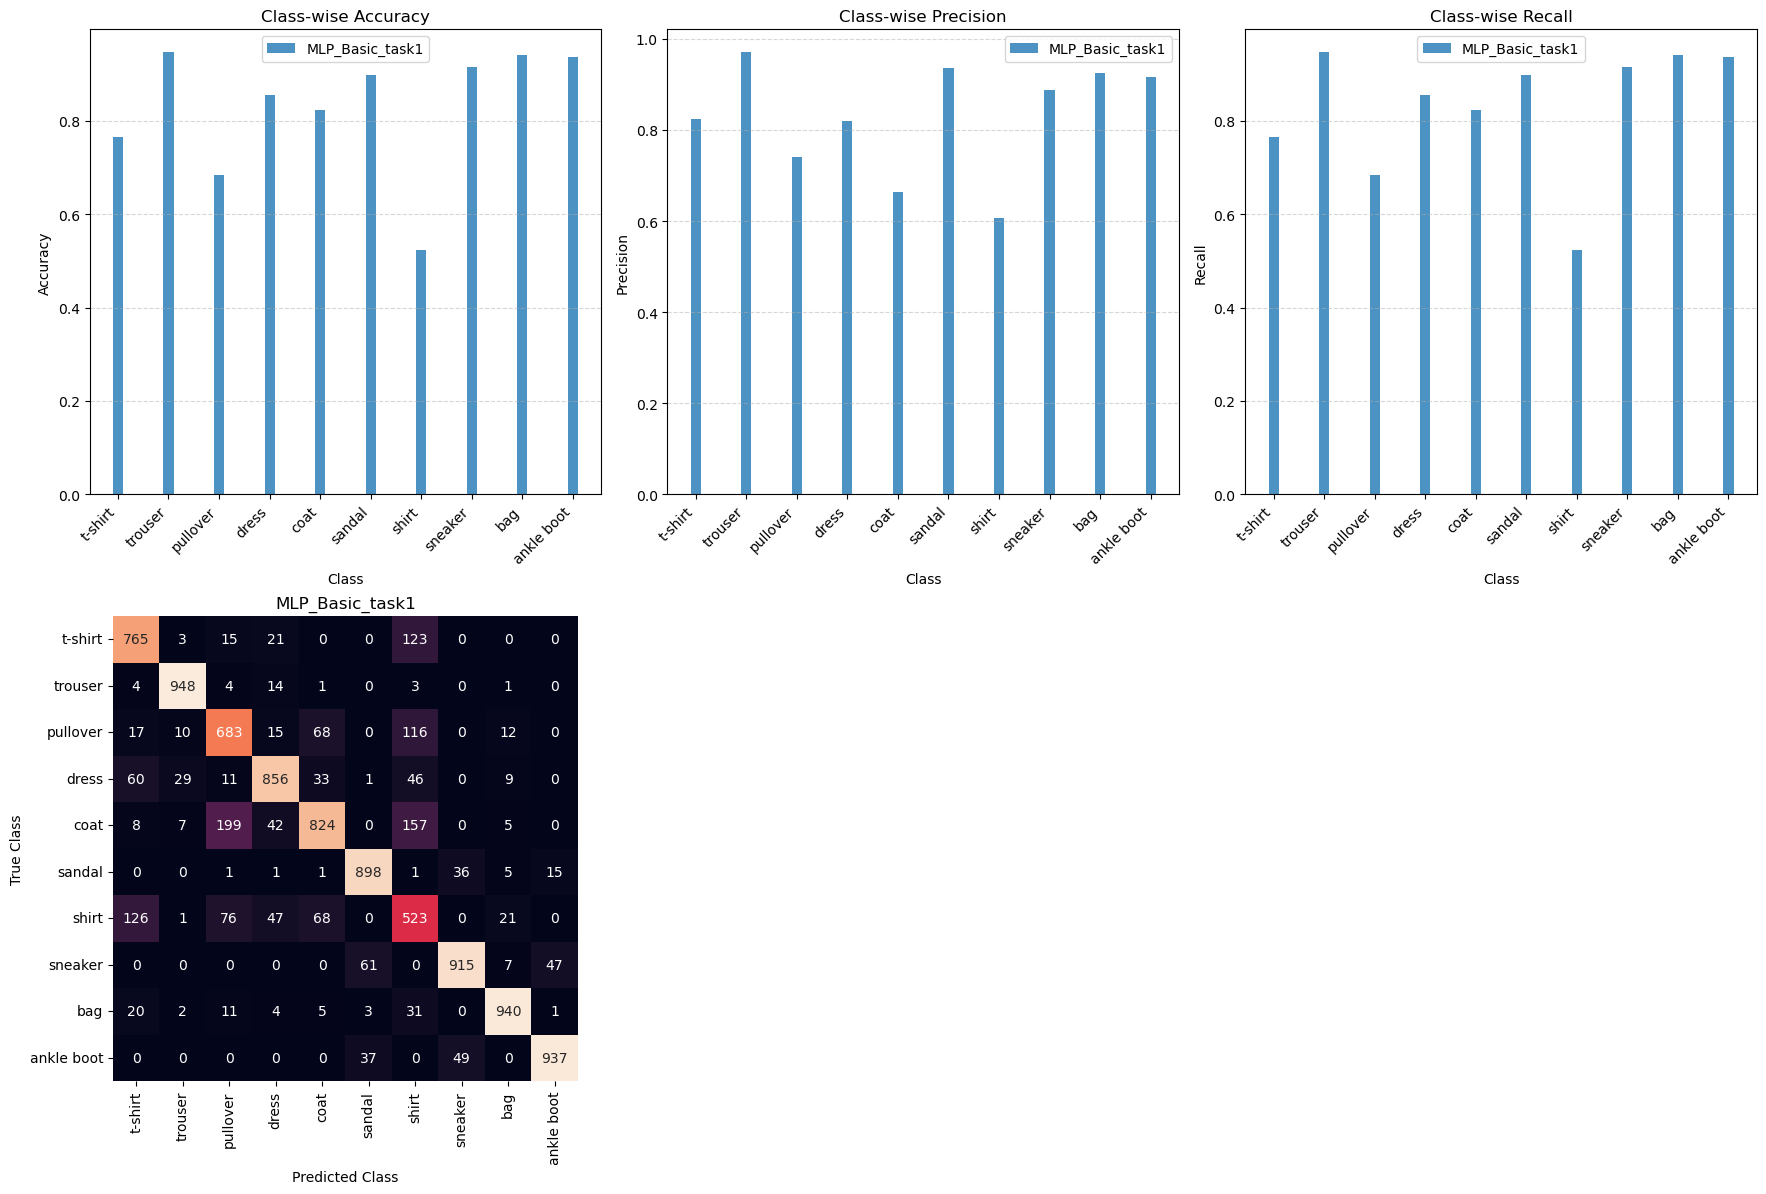

In [8]:
file_mlp_basic = train_pytorch_network_mlp(
    hidden_layers=[100],          # Single hidden layer as per MLPBasic architecture
    activation_fn='relu',         # Default activation function
    learning_rate=1e-2,           # Same learning rate as before
    batch_size=128,               # Same batch size as before
    epochs=10,                    # Same number of epochs
    model_name="MLPBasic_task1"         # Model name for filename generation
)

print(f"MLPBasic model saved at: {file_mlp_basic}")

# Load models dynamically using the returned filenames
MLP_models = {
    'MLP_Basic_task1': PyTorchTrainer.load(file_mlp_basic)
}

# Visualize class-wise metrics
evaluate(MLP_models)



---
**Task 2 (easy): Evaluation💡**
1. Evaluate the performance of the model during training:    - Inspect the accuracy, loss and training time. What patterns or trends do you observe in the loss and accuracy graphs throughout training?




---

## Task 2 reflection

1. **Training Time**:
   - The training process took approximately 116.85 seconds for 10 epochs.
   - Each epoch had consistent progress rates, with the validation step slightly faster than the training step.

2. **Loss Trends**:
   - The **training loss** decreased consistently, indicating that the model was learning to minimize the classification error on the training set.
   - The **validation loss** also decreased but at a slower rate than the training loss, showing improvement in generalization.

3. **Accuracy Trends**:
   - Both **training accuracy** and **validation accuracy** increased steadily throughout training.
   - By the 10th epoch, the training accuracy reached approximately **58.51%**, and validation accuracy was around **66.06%**.

4. **Class-Wise Metrics**:
   - **Trouser, Sneaker, and Ankle Boot** classes achieved high precision and recall values, indicating that the model effectively distinguished these classes.
   - **Shirt** had lower precision and recall, showing that the model struggled with this category, likely due to similar features with other classes like T-Shirts or Pullovers.

#### Trends:
- The model's validation accuracy lagged behind the training accuracy, which is expected as the validation set is unseen during training.
- Validation loss continued to decrease, indicating that overfitting was not yet a significant issue after 10 epochs.
- Certain classes (e.g., Sandals, Bags) consistently performed better, highlighting potential differences in feature representation quality.

#### Conclusion:
The trends observed in the accuracy and loss graphs align with expectations for a basic MLP trained on a moderately complex dataset like FashionMNIST. While the model shows good improvement during training, further architectural or hyperparameter tuning might improve the performance, particularly for challenging classes like Shirts.



The next task experiments with different hyperparameters. Use the function`evaluate_overall_metrics`
 to visualize and compare the overall performance of the models and use the `evaluate`
 function to visualise and compare the performance of the models class-wise. [Figure 1](#ex) provides an example of the type of plots returned by the functions.
<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">

<div style="float: left; width: 50%; justify-content: start" class="block is-clearfix">

<div class="has-text-centered">
<figure class="image is-inline-block" id="ex">

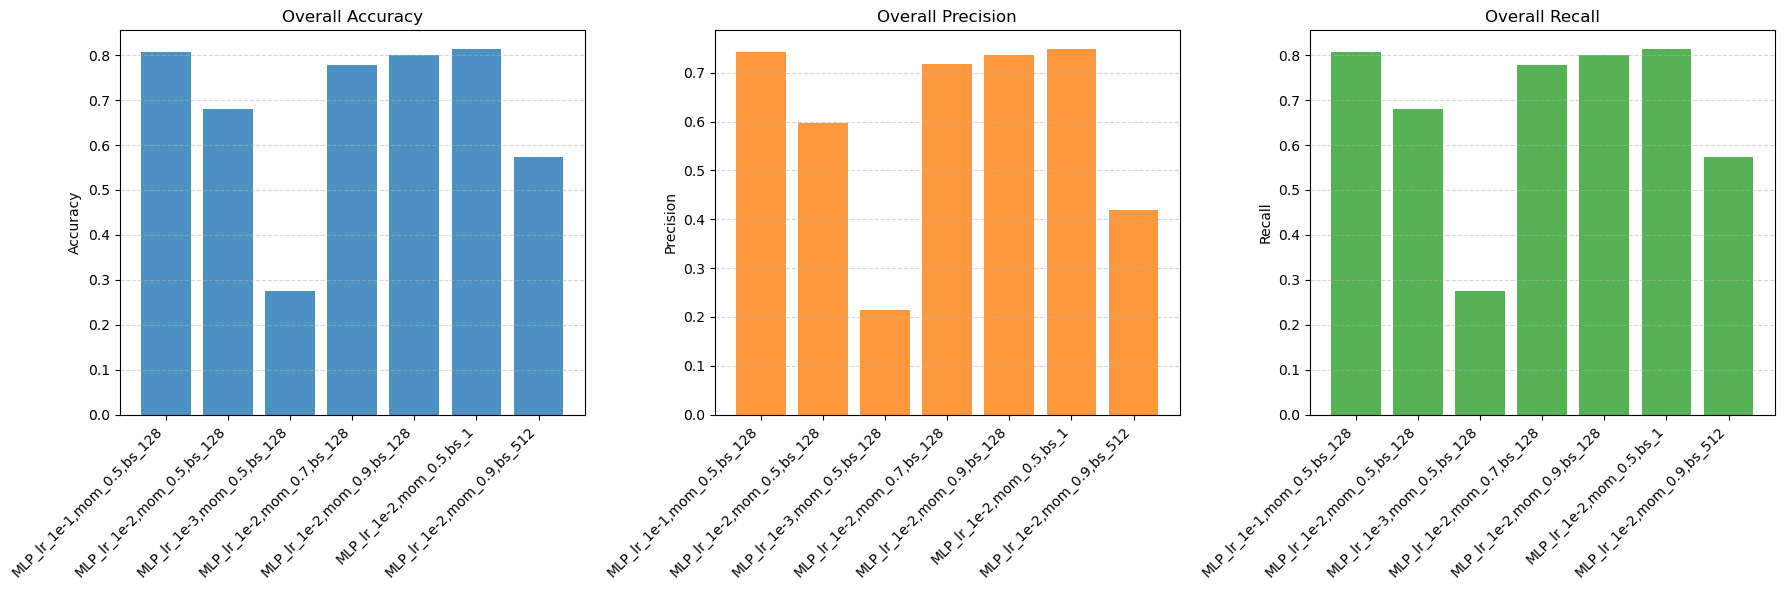

<figcaption class="figure-caption has-text-center">Figure 1: Example of output from the `evaluate_overall_metrics`
 function.
</figcaption>
</figure>
</div>


</div>

<div style="float: right; width: 50%; justify-content: start" class="block is-clearfix">

<div class="has-text-centered">
<figure class="image is-inline-block" id="model">

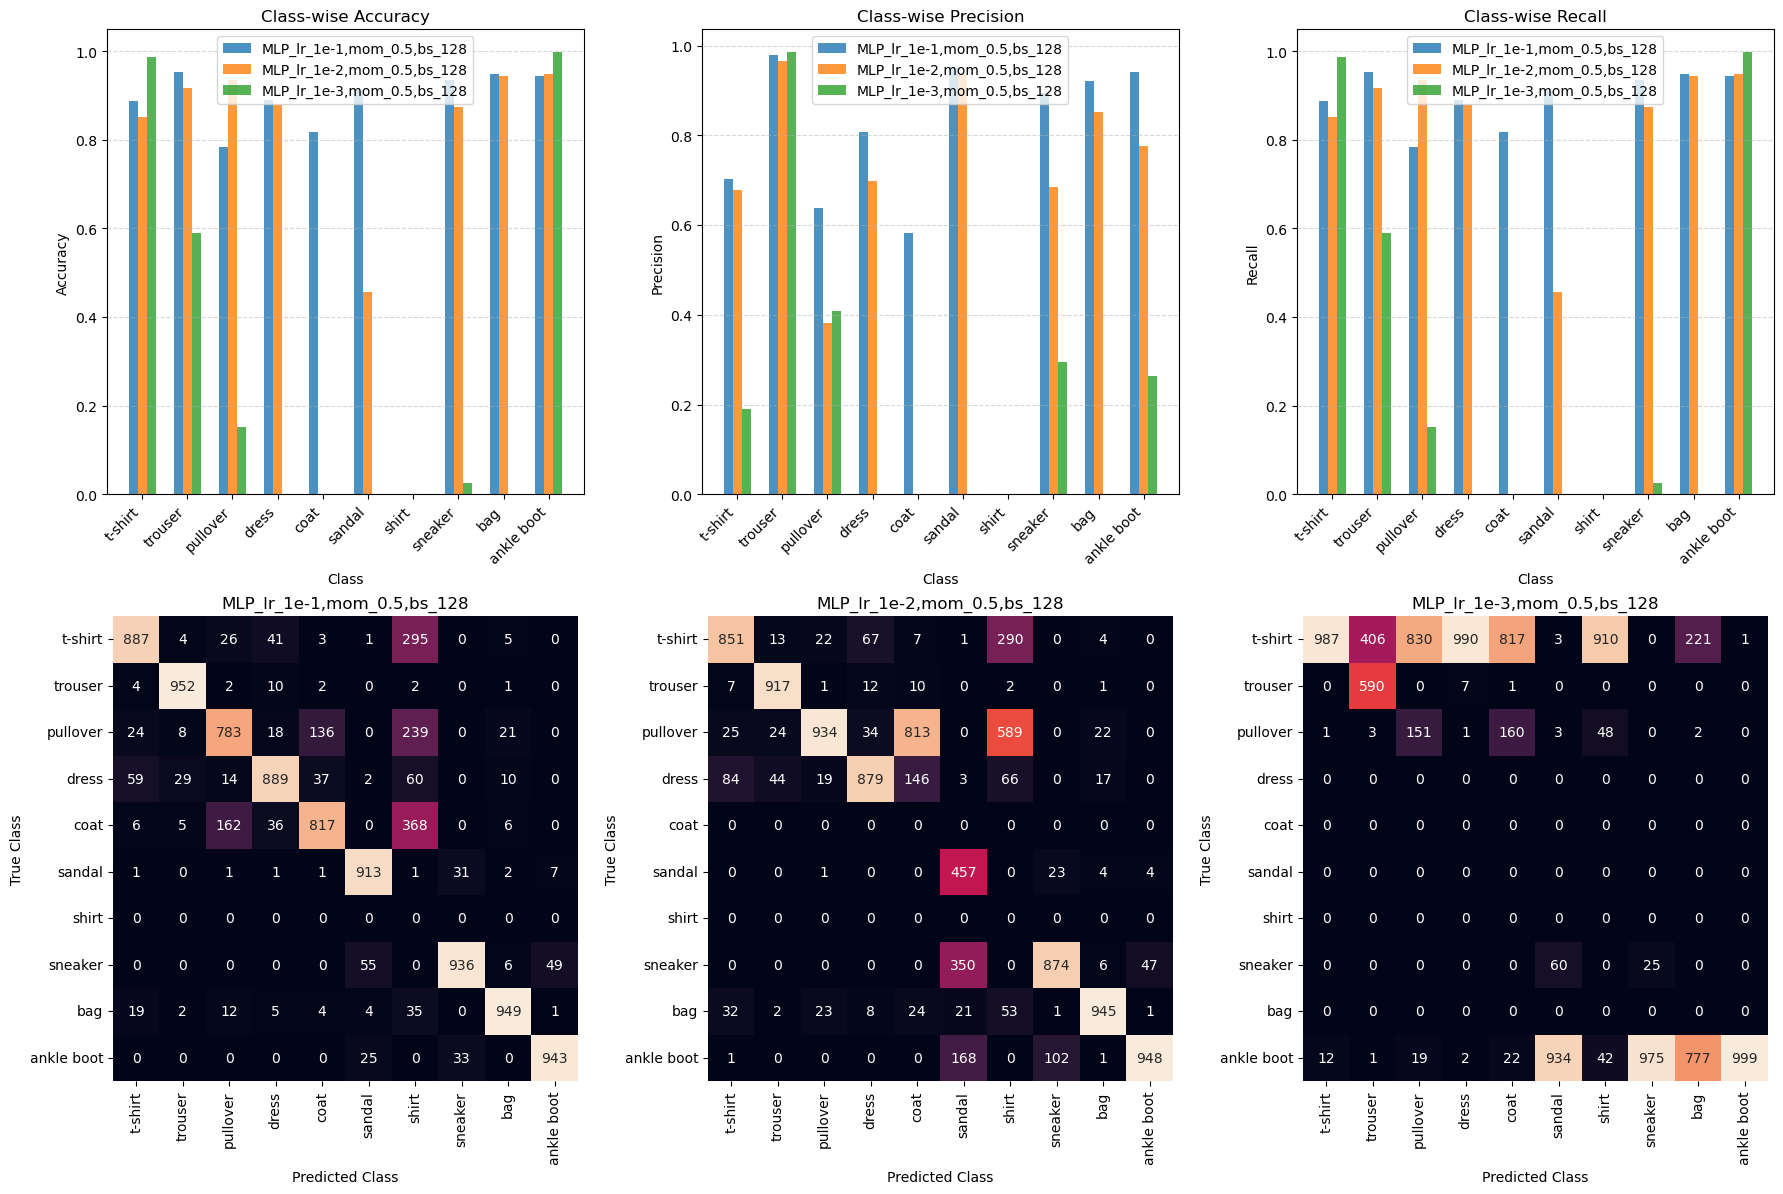

<figcaption class="figure-caption has-text-center">Figure 2: Example of output from the `evaluate`
 function.
</figcaption>
</figure>
</div>


</div>



</div>


---
**Task 3 (easy): Training basic MLP modifying hyperparameters👩‍💻**
1. Explore how different hyperparameters influence the training and performance of the model:
    - Modify training variables and train new models:        - Set the learning rate to 1e-3, and 1e-1. 
        - Reset the learning rate to 1e-2 then modify the batch size to 1 and 512. 


    - Fill the dictionaries below with the paths of the trained models.
    - Visualize the overall metrics of performance for all models trained using the `evaluate_overall_metrics`
 function.
    - Visualize the performance by running the `evaluate`
 function.


**Hint**
The cell below is a guide for how to load the models after training. The models are located in the `models`
 folder.




---

Skipping training for MLP_LR_1e-3. Returning filename: models/MLP_LR_1e-3_lr0p001_bs128.pkl
Skipping training for MLP_LR_1e-1. Returning filename: models/MLP_LR_1e-1_lr0p1_bs128.pkl
Skipping training for MLP_BS_1. Returning filename: models/MLP_BS_1_lr0p01_bs1.pkl
Skipping training for MLP_BS_512. Returning filename: models/MLP_BS_512_lr0p01_bs512.pkl


100%|██████████| 20/20 [00:01<00:00, 11.77it/s]


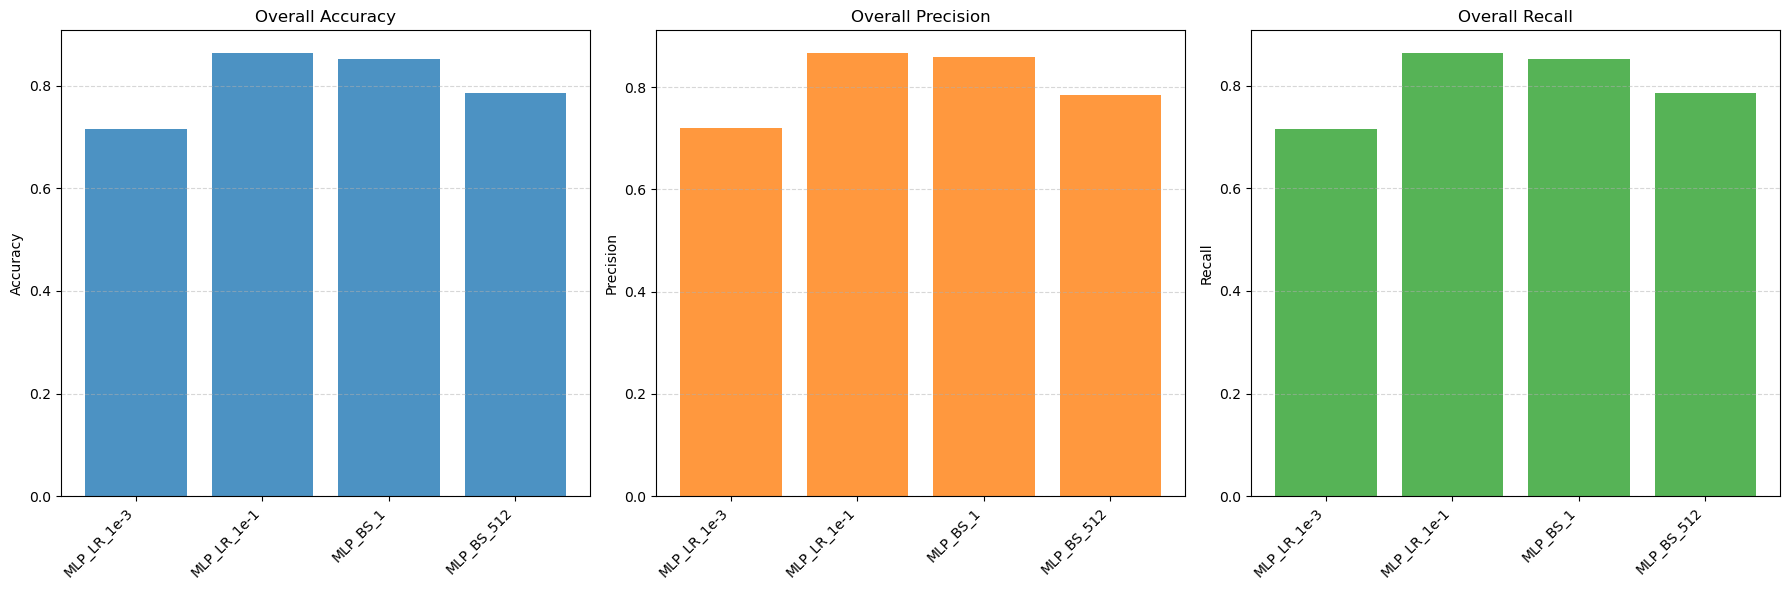

100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


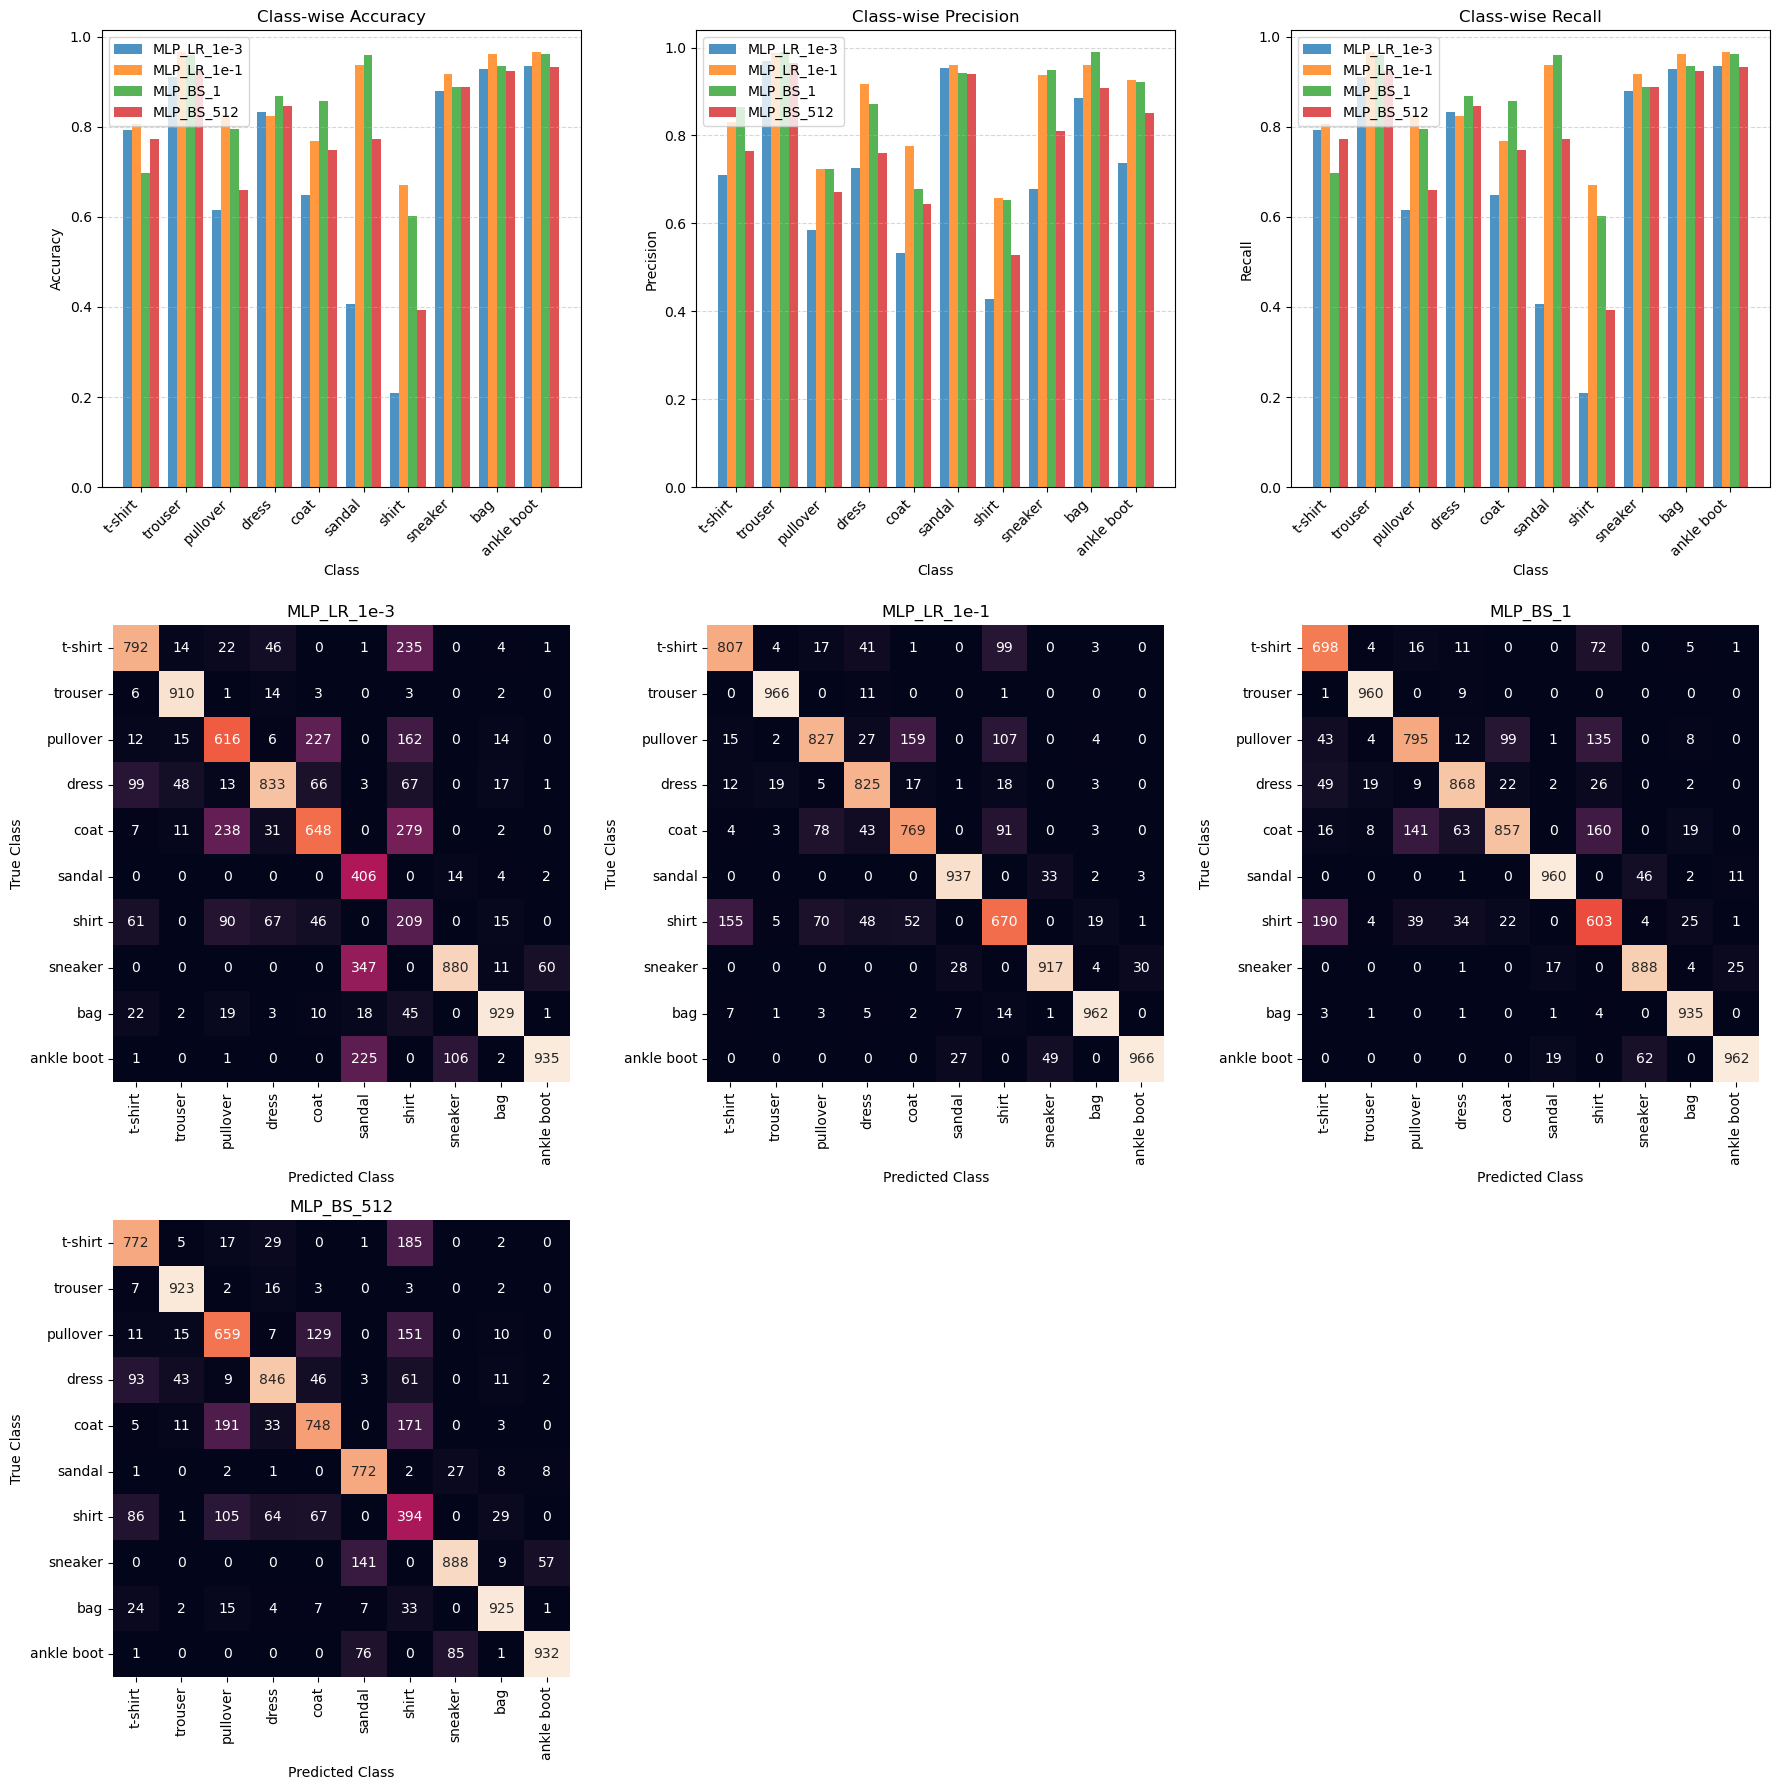

In [9]:
# Train MLP models with different hyperparameters
file_lr_1e3_bs_128 = train_pytorch_network_mlp(
    hidden_layers=[100], 
    activation_fn='relu', 
    learning_rate=1e-3, 
    batch_size=128, 
    epochs=10, 
    model_name="MLP_LR_1e-3"
)

file_lr_1e1_bs_128 = train_pytorch_network_mlp(
    hidden_layers=[100], 
    activation_fn='relu', 
    learning_rate=1e-1, 
    batch_size=128, 
    epochs=10, 
    model_name="MLP_LR_1e-1"
)

file_lr_1e2_bs_1 = train_pytorch_network_mlp(
    hidden_layers=[100], 
    activation_fn='relu', 
    learning_rate=1e-2, 
    batch_size=1, 
    epochs=10, 
    model_name="MLP_BS_1"
)

file_lr_1e2_bs_512 = train_pytorch_network_mlp(
    hidden_layers=[100], 
    activation_fn='relu', 
    learning_rate=1e-2, 
    batch_size=512, 
    epochs=10, 
    model_name="MLP_BS_512"
)

# Load models dynamically using the returned filenames
MLP_models = {
    'MLP_LR_1e-3': PyTorchTrainer.load(file_lr_1e3_bs_128),
    'MLP_LR_1e-1': PyTorchTrainer.load(file_lr_1e1_bs_128),
    'MLP_BS_1': PyTorchTrainer.load(file_lr_1e2_bs_1),
    'MLP_BS_512': PyTorchTrainer.load(file_lr_1e2_bs_512),
}

# Visualize overall metrics
evaluate_overall_metrics(MLP_models)

# Visualize class-wise metrics
evaluate(MLP_models)



---
**Task 4 (easy): Comparison💡**
1. Compare the performance of the models:    - Evaluate the models using accuracy, precision, recall, and heatmaps.
    - Discuss how the changes in hyperparameters, such as learning rate and batch size, influence these performance metrics. Highlight any trends or trade-offs observed, such as improvements in accuracy versus potential declines in precision or recall.


2. How is the training time affected by the different hyperparameters?


---

## Task 4 reflection.



### Convolutional Neural Network
The following tasks investigate a CNN architecture for the same problem.

---
**Task 5 (easy): CNN architecture💡**
1. Locate the `CNNBasic`
 model defined in `networks.py`
 and explain the architecture.


---

## Task 5 reflection


#### `CNNBasic` Architecture
The `CNNBasic` model is a **convolutional neural network (CNN)** designed for image classification. Below is a breakdown of its architecture:

1. **Convolutional Layer 1**:
   - Input: \( 1 \)-channel grayscale image (e.g., \( 28 \times 28 \)).
   - Applies \( 8 \) convolutional kernels (filters), each of size \( 9 \times 9 \).
   - Activation: ReLU.
   - Output Size: \( (28 - 9 + 1) \times (28 - 9 + 1) = 20 \times 20 \).

2. **Max Pooling 1**:
   - Pooling window size: \( 2 \times 2 \).
   - Stride: \( 2 \).
   - Output Size: \( 20 / 2 = 10 \times 10 \).

3. **Convolutional Layer 2**:
   - Input: \( 8 \)-channel feature map from the previous layer.
   - Applies \( 16 \) convolutional kernels, each of size \( 3 \times 3 \).
   - Activation: ReLU.
   - Output Size: \( (10 - 3 + 1) \times (10 - 3 + 1) = 8 \times 8 \).

4. **Max Pooling 2**:
   - Pooling window size: \( 2 \times 2 \).
   - Stride: \( 2 \).
   - Output Size: \( 8 / 2 = 4 \times 4 \).

5. **Flattening**:
   - The feature maps from the convolutional layers are flattened into a \( 4^2 \times 16 = 256 \)-dimensional vector.

6. **Fully Connected (Linear) Layer 1**:
   - Input: \( 256 \)-dimensional vector.
   - Output: \( 60 \) neurons.
   - Activation: ReLU.

7. **Fully Connected (Linear) Layer 2**:
   - Input: \( 60 \)-dimensional vector.
   - Output: \( 10 \) neurons (one for each class in FashionMNIST).
   - No activation applied, as this layer typically feeds into a softmax layer for classification.



---
**Task 6 (easy): Training a basic CNN👩‍💻**
1. Run the cell below to train the `CNNBasic`
 model.


---

Training CNNBasic...
[Epoch 1]


100%|██████████| 94/94 [00:03<00:00, 30.72it/s]


[Validation] Epoch 1: acc: 0.6770, val_loss: 0.8518, train_acc: 0.4884
[Epoch 2]


100%|██████████| 94/94 [00:02<00:00, 31.86it/s]


[Validation] Epoch 2: acc: 0.7382, val_loss: 0.7204, train_acc: 0.5975
[Epoch 3]


100%|██████████| 94/94 [00:02<00:00, 31.63it/s]


[Validation] Epoch 3: acc: 0.7670, val_loss: 0.6273, train_acc: 0.6439
[Epoch 4]


100%|██████████| 94/94 [00:03<00:00, 30.83it/s]


[Validation] Epoch 4: acc: 0.7833, val_loss: 0.5786, train_acc: 0.6728
[Epoch 5]


100%|██████████| 94/94 [00:03<00:00, 29.86it/s]


[Validation] Epoch 5: acc: 0.7843, val_loss: 0.5687, train_acc: 0.6941
[Epoch 6]


100%|██████████| 94/94 [00:02<00:00, 31.75it/s]


[Validation] Epoch 6: acc: 0.8010, val_loss: 0.5282, train_acc: 0.7104
[Epoch 7]


100%|██████████| 94/94 [00:03<00:00, 28.70it/s]


[Validation] Epoch 7: acc: 0.8156, val_loss: 0.4975, train_acc: 0.7242
[Epoch 8]


100%|██████████| 94/94 [00:02<00:00, 32.73it/s]


[Validation] Epoch 8: acc: 0.8304, val_loss: 0.4635, train_acc: 0.7361
[Epoch 9]


100%|██████████| 94/94 [00:03<00:00, 30.31it/s]


[Validation] Epoch 9: acc: 0.8407, val_loss: 0.4369, train_acc: 0.7465
[Epoch 10]


100%|██████████| 94/94 [00:02<00:00, 32.19it/s]


[Validation] Epoch 10: acc: 0.8434, val_loss: 0.4380, train_acc: 0.7557


100%|██████████| 79/79 [00:02<00:00, 28.66it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x00000222461DA350>


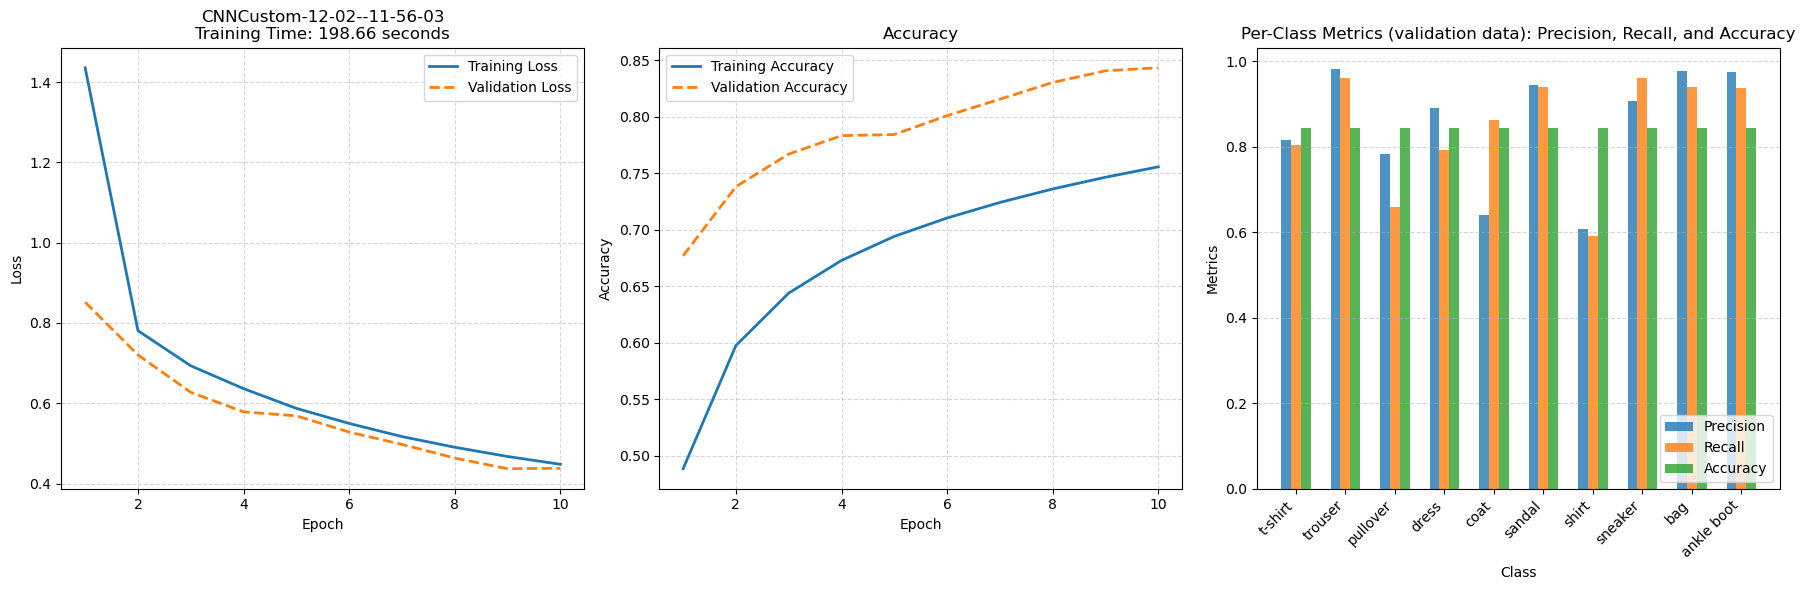

Model saved to: models\CNNBasic_lr0p01_bs128.pkl
Training and evaluation completed. Model saved at: models/CNNBasic_lr0p01_bs128.pkl
CNNBasic model saved at: models/CNNBasic_lr0p01_bs128.pkl


In [10]:
# Train the CNNBasic model

SKIP_TRAINING = False

file_cnn_basic = train_pytorch_network_cnn(
    input_channels=1,             # Grayscale images
    conv_layers=[(16, 5), (32, 3)], # Default CNNBasic architecture: 2 conv layers
    fc_layers=[128, 10],          # Fully connected layers
    activation_fn='relu',         # Default activation function
    learning_rate=1e-2,           # Learning rate as before
    batch_size=128,               # Batch size as before
    epochs=10,                    # Number of epochs
    model_name="CNNBasic"         # Custom model name
)

print(f"CNNBasic model saved at: {file_cnn_basic}")



---
**Task 7 (easy): Evaluation👩‍💻💡**
1. Analyze the training figures and describe the key characteristics of the model’s training process.


---

In [11]:
# Write your reflections here...


---
**Task 8 (easy): Training a basic CNN modifying hyperparameters👩‍💻💡**
1. Experiment with the different hyperparameters affecting the training and performance of the model.    - Modify the following hyperparameters and train new model:        - Set the learning rate to 1e-4, and 1e-5. 
        - Modify the batch size to 256 and 1024. 


    - Fill the dictionary below with the paths of the trained models.
    - Visualize the overall performance by running `evaluate_overall_metrics`
 function.
    - Visualize the class-wise performance by running the `evaluate`
 function.




---

Training CNN_LR_1e-4_BS128...
[Epoch 1]


100%|██████████| 94/94 [00:02<00:00, 34.46it/s]


[Validation] Epoch 1: acc: 0.1122, val_loss: 2.3030, train_acc: 0.1160
[Epoch 2]


100%|██████████| 94/94 [00:03<00:00, 24.56it/s]


[Validation] Epoch 2: acc: 0.1050, val_loss: 2.3004, train_acc: 0.1116
[Epoch 3]


100%|██████████| 94/94 [00:06<00:00, 15.37it/s]


[Validation] Epoch 3: acc: 0.1026, val_loss: 2.2979, train_acc: 0.1086
[Epoch 4]


100%|██████████| 94/94 [00:02<00:00, 31.98it/s]


[Validation] Epoch 4: acc: 0.1013, val_loss: 2.2955, train_acc: 0.1067
[Epoch 5]


100%|██████████| 94/94 [00:03<00:00, 26.91it/s]


[Validation] Epoch 5: acc: 0.1009, val_loss: 2.2930, train_acc: 0.1055
[Epoch 6]


100%|██████████| 94/94 [00:04<00:00, 23.12it/s]


[Validation] Epoch 6: acc: 0.1009, val_loss: 2.2904, train_acc: 0.1046
[Epoch 7]


100%|██████████| 94/94 [00:04<00:00, 23.04it/s]


[Validation] Epoch 7: acc: 0.1006, val_loss: 2.2876, train_acc: 0.1039
[Epoch 8]


100%|██████████| 94/94 [00:02<00:00, 32.73it/s]


[Validation] Epoch 8: acc: 0.1013, val_loss: 2.2847, train_acc: 0.1035
[Epoch 9]


100%|██████████| 94/94 [00:03<00:00, 31.07it/s]


[Validation] Epoch 9: acc: 0.1034, val_loss: 2.2816, train_acc: 0.1033
[Epoch 10]


100%|██████████| 94/94 [00:03<00:00, 30.84it/s]


[Validation] Epoch 10: acc: 0.1101, val_loss: 2.2782, train_acc: 0.1034


100%|██████████| 79/79 [00:02<00:00, 29.00it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x00000222470A7670>


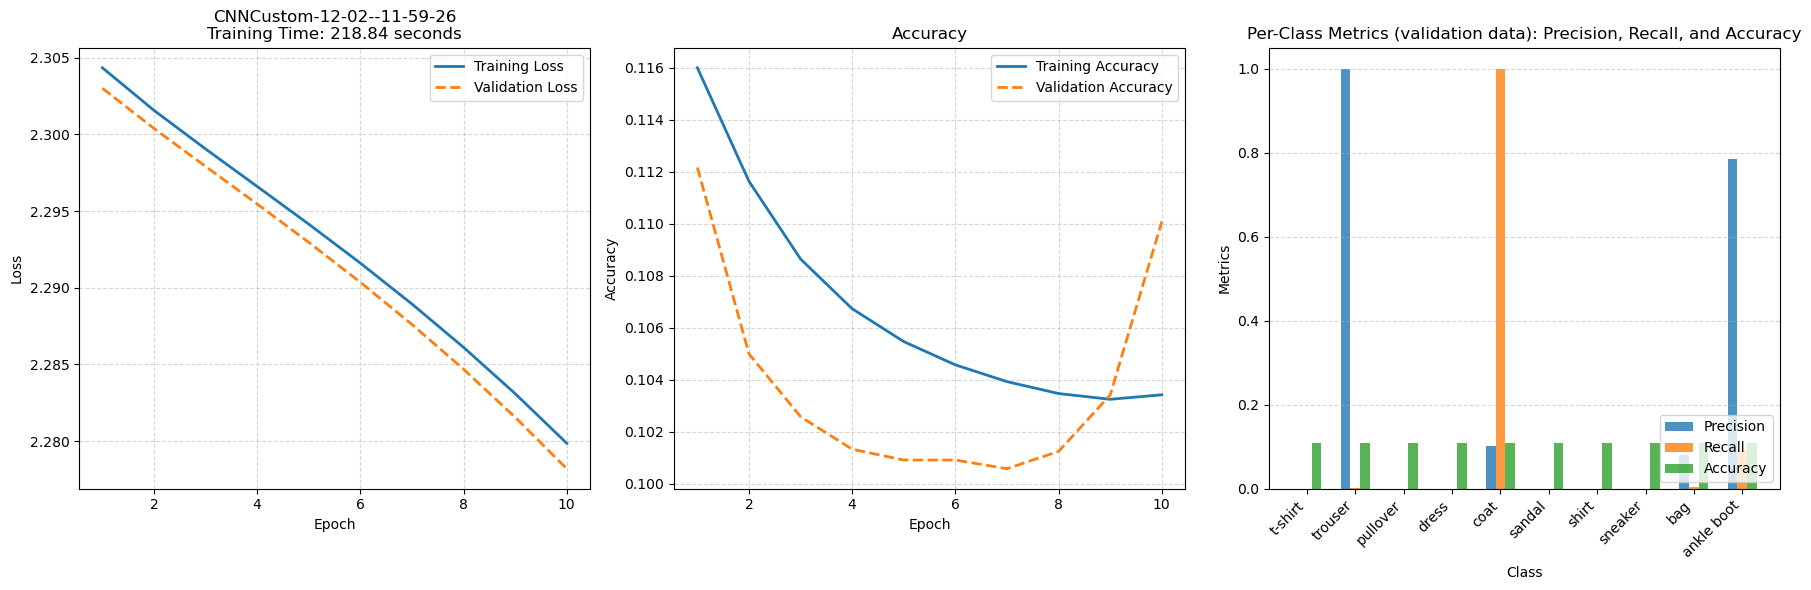

Model saved to: models\CNN_LR_1e-4_BS128_lr0p0001_bs128.pkl
Training and evaluation completed. Model saved at: models/CNN_LR_1e-4_BS128_lr0p0001_bs128.pkl
Training CNN_LR_1e-5_BS128...
[Epoch 1]


100%|██████████| 94/94 [00:03<00:00, 28.86it/s]


[Validation] Epoch 1: acc: 0.0819, val_loss: 2.3034, train_acc: 0.0781
[Epoch 2]


100%|██████████| 94/94 [00:03<00:00, 30.95it/s]


[Validation] Epoch 2: acc: 0.0838, val_loss: 2.3032, train_acc: 0.0789
[Epoch 3]


100%|██████████| 94/94 [00:02<00:00, 32.34it/s]


[Validation] Epoch 3: acc: 0.0851, val_loss: 2.3030, train_acc: 0.0796
[Epoch 4]


100%|██████████| 94/94 [00:03<00:00, 31.07it/s]


[Validation] Epoch 4: acc: 0.0865, val_loss: 2.3028, train_acc: 0.0802
[Epoch 5]


100%|██████████| 94/94 [00:03<00:00, 29.05it/s]


[Validation] Epoch 5: acc: 0.0875, val_loss: 2.3026, train_acc: 0.0809
[Epoch 6]


100%|██████████| 94/94 [00:03<00:00, 28.81it/s]


[Validation] Epoch 6: acc: 0.0888, val_loss: 2.3024, train_acc: 0.0815
[Epoch 7]


100%|██████████| 94/94 [00:03<00:00, 30.24it/s]


[Validation] Epoch 7: acc: 0.0908, val_loss: 2.3022, train_acc: 0.0822
[Epoch 8]


100%|██████████| 94/94 [00:02<00:00, 32.06it/s]


[Validation] Epoch 8: acc: 0.0927, val_loss: 2.3020, train_acc: 0.0830
[Epoch 9]


100%|██████████| 94/94 [00:02<00:00, 31.69it/s]


[Validation] Epoch 9: acc: 0.0947, val_loss: 2.3018, train_acc: 0.0837
[Epoch 10]


100%|██████████| 94/94 [00:02<00:00, 32.05it/s]


[Validation] Epoch 10: acc: 0.0962, val_loss: 2.3016, train_acc: 0.0846


100%|██████████| 79/79 [00:02<00:00, 30.07it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x00000222470A79A0>


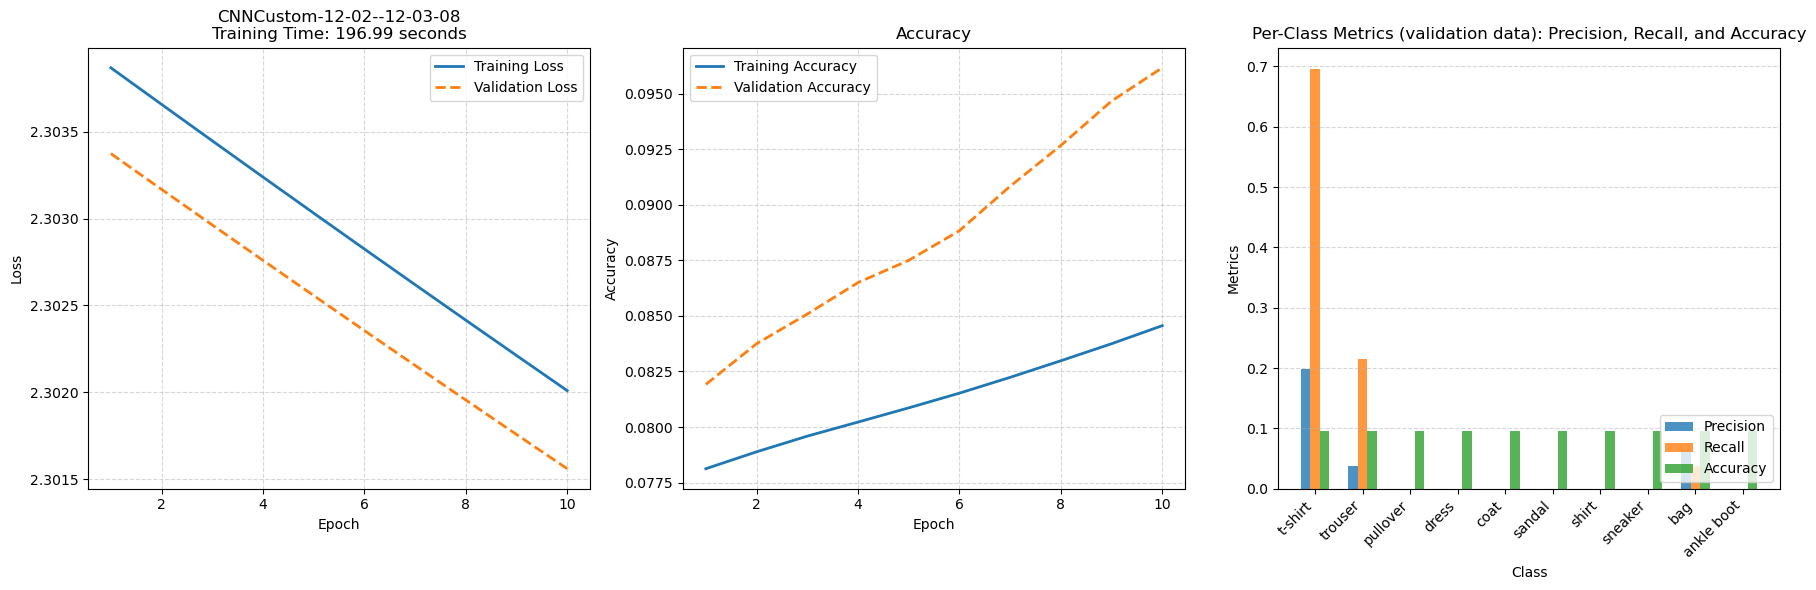

Model saved to: models\CNN_LR_1e-5_BS128_lr1e-05_bs128.pkl
Training and evaluation completed. Model saved at: models/CNN_LR_1e-5_BS128_lr1e-05_bs128.pkl
Training CNN_LR_1e-4_BS256...
[Epoch 1]


100%|██████████| 47/47 [00:02<00:00, 15.84it/s]


[Validation] Epoch 1: acc: 0.1063, val_loss: 2.3018, train_acc: 0.1024
[Epoch 2]


100%|██████████| 47/47 [00:02<00:00, 15.76it/s]


[Validation] Epoch 2: acc: 0.1115, val_loss: 2.3009, train_acc: 0.1053
[Epoch 3]


100%|██████████| 47/47 [00:03<00:00, 13.45it/s]


[Validation] Epoch 3: acc: 0.1148, val_loss: 2.3001, train_acc: 0.1076
[Epoch 4]


100%|██████████| 47/47 [00:03<00:00, 13.46it/s]


[Validation] Epoch 4: acc: 0.1168, val_loss: 2.2993, train_acc: 0.1091
[Epoch 5]


100%|██████████| 47/47 [00:04<00:00,  9.48it/s]


[Validation] Epoch 5: acc: 0.1172, val_loss: 2.2985, train_acc: 0.1102
[Epoch 6]


100%|██████████| 47/47 [00:03<00:00, 15.30it/s]


[Validation] Epoch 6: acc: 0.1177, val_loss: 2.2977, train_acc: 0.1111
[Epoch 7]


100%|██████████| 47/47 [00:03<00:00, 13.49it/s]


[Validation] Epoch 7: acc: 0.1176, val_loss: 2.2970, train_acc: 0.1117
[Epoch 8]


100%|██████████| 47/47 [00:04<00:00,  9.72it/s]


[Validation] Epoch 8: acc: 0.1178, val_loss: 2.2962, train_acc: 0.1122
[Epoch 9]


100%|██████████| 47/47 [00:03<00:00, 14.47it/s]


[Validation] Epoch 9: acc: 0.1177, val_loss: 2.2954, train_acc: 0.1126
[Epoch 10]


100%|██████████| 47/47 [00:02<00:00, 16.91it/s]


[Validation] Epoch 10: acc: 0.1175, val_loss: 2.2946, train_acc: 0.1129


100%|██████████| 40/40 [00:02<00:00, 16.32it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x0000022246FEDFC0>


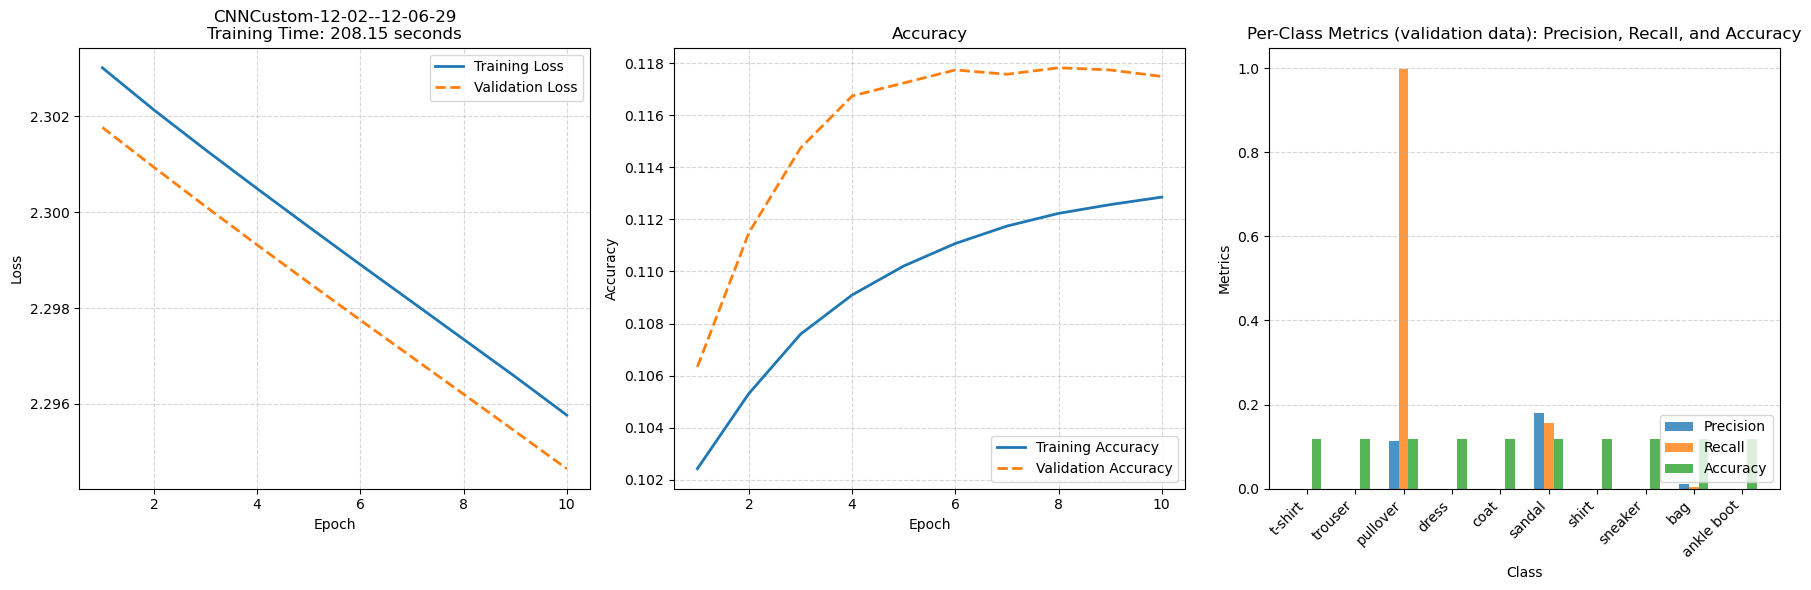

Model saved to: models\CNN_LR_1e-4_BS256_lr0p0001_bs256.pkl
Training and evaluation completed. Model saved at: models/CNN_LR_1e-4_BS256_lr0p0001_bs256.pkl
Training CNN_LR_1e-4_BS1024...
[Epoch 1]


100%|██████████| 12/12 [00:02<00:00,  4.04it/s]


[Validation] Epoch 1: acc: 0.0991, val_loss: 2.3016, train_acc: 0.1002
[Epoch 2]


100%|██████████| 12/12 [00:03<00:00,  3.37it/s]


[Validation] Epoch 2: acc: 0.0991, val_loss: 2.3014, train_acc: 0.1002
[Epoch 3]


100%|██████████| 12/12 [00:02<00:00,  4.54it/s]


[Validation] Epoch 3: acc: 0.0991, val_loss: 2.3013, train_acc: 0.1002
[Epoch 4]


100%|██████████| 12/12 [00:02<00:00,  4.64it/s]


[Validation] Epoch 4: acc: 0.0991, val_loss: 2.3011, train_acc: 0.1002
[Epoch 5]


100%|██████████| 12/12 [00:02<00:00,  4.31it/s]


[Validation] Epoch 5: acc: 0.0991, val_loss: 2.3010, train_acc: 0.1002
[Epoch 6]


100%|██████████| 12/12 [00:03<00:00,  3.97it/s]


[Validation] Epoch 6: acc: 0.0991, val_loss: 2.3008, train_acc: 0.1002
[Epoch 7]


100%|██████████| 12/12 [00:02<00:00,  4.10it/s]


[Validation] Epoch 7: acc: 0.0991, val_loss: 2.3007, train_acc: 0.1002
[Epoch 8]


100%|██████████| 12/12 [00:03<00:00,  3.61it/s]


[Validation] Epoch 8: acc: 0.0991, val_loss: 2.3005, train_acc: 0.1002
[Epoch 9]


100%|██████████| 12/12 [00:02<00:00,  4.47it/s]


[Validation] Epoch 9: acc: 0.0991, val_loss: 2.3004, train_acc: 0.1002
[Epoch 10]


100%|██████████| 12/12 [00:02<00:00,  4.62it/s]


[Validation] Epoch 10: acc: 0.0991, val_loss: 2.3002, train_acc: 0.1002


100%|██████████| 10/10 [00:02<00:00,  4.36it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x0000022247D53970>


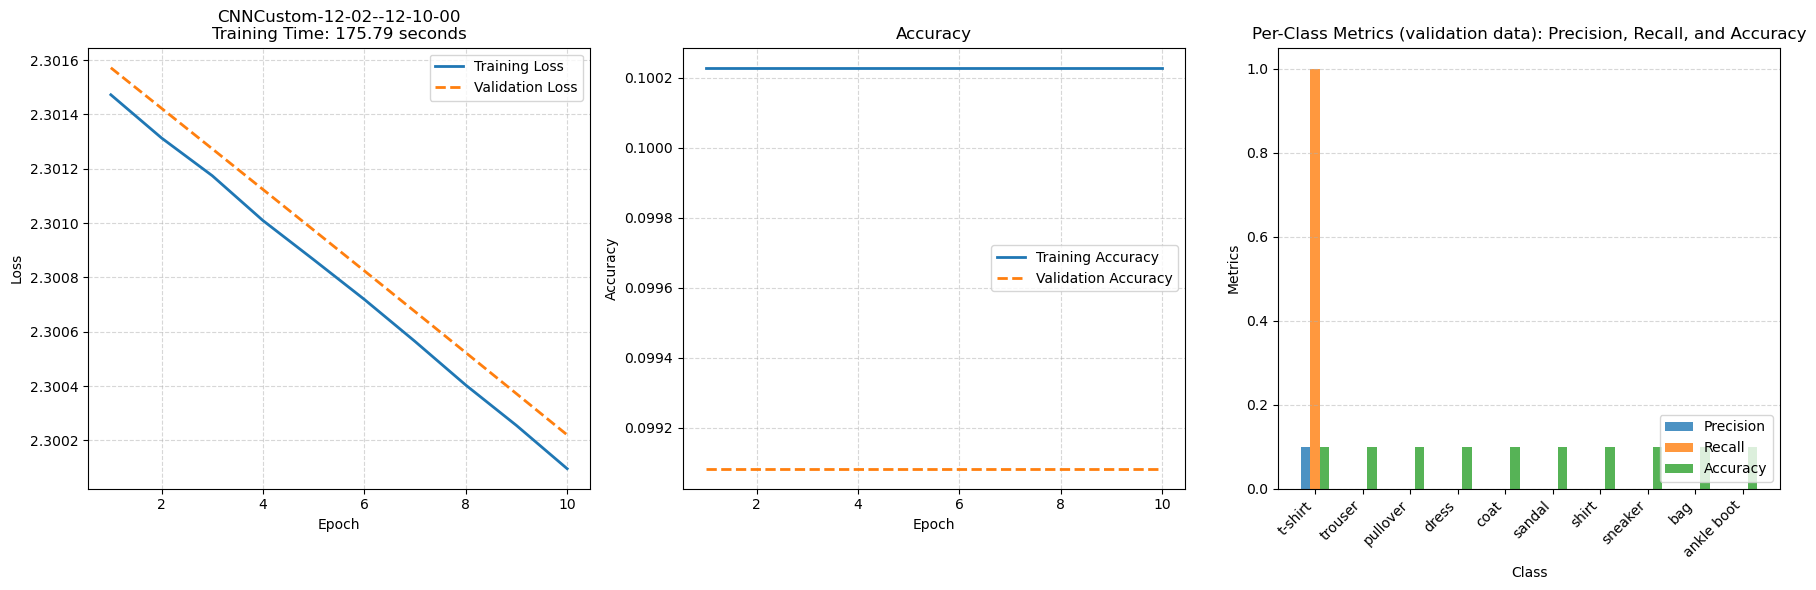

Model saved to: models\CNN_LR_1e-4_BS1024_lr0p0001_bs1024.pkl
Training and evaluation completed. Model saved at: models/CNN_LR_1e-4_BS1024_lr0p0001_bs1024.pkl


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


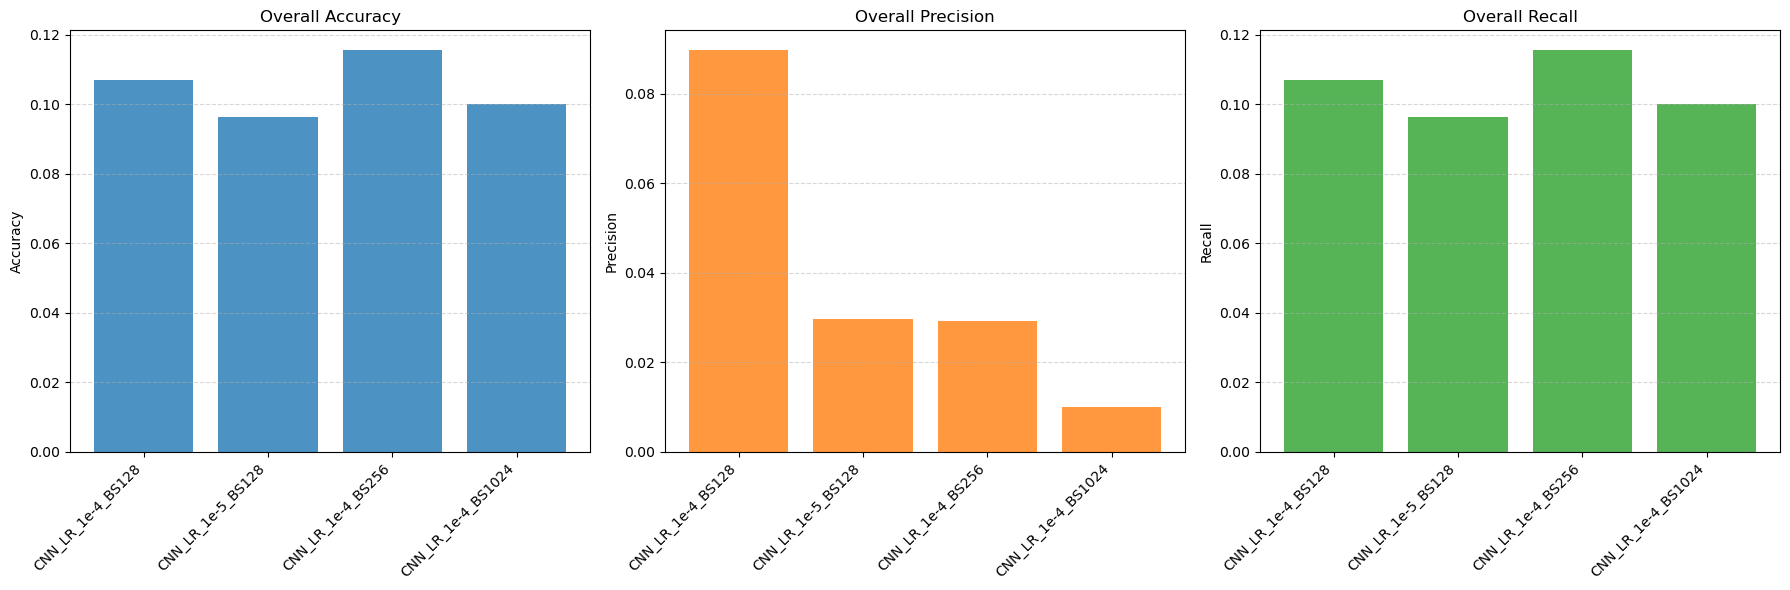

100%|██████████| 10/10 [00:02<00:00,  4.39it/s]


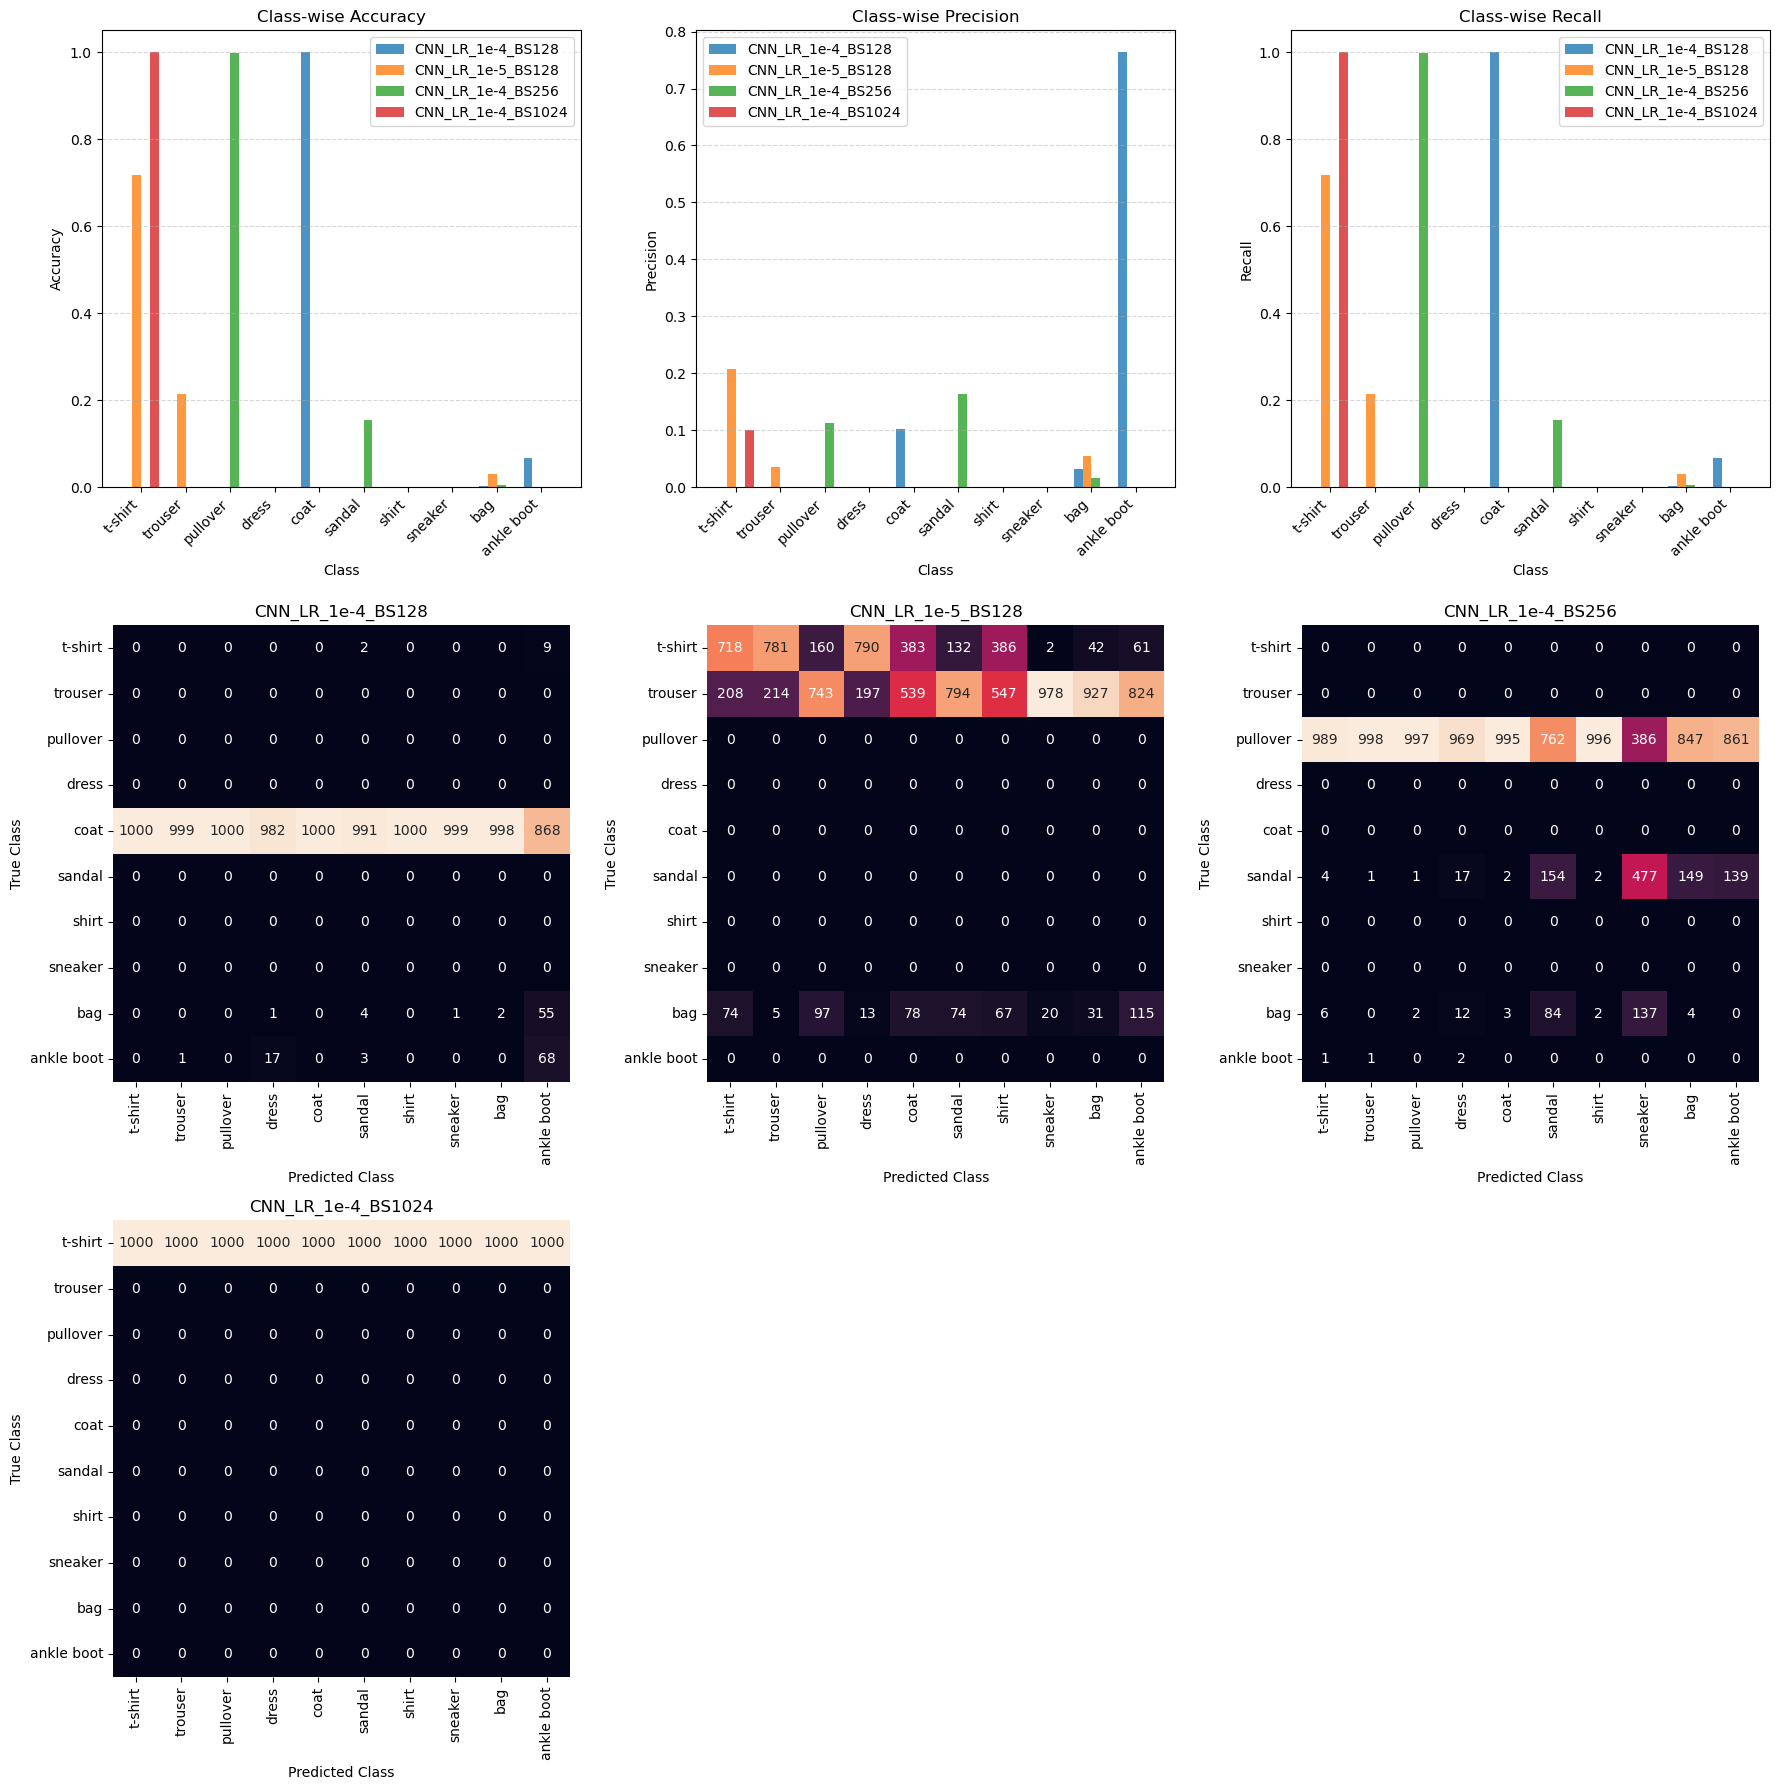

In [12]:
# Train CNN models with different hyperparameters
file_lr_1e4_bs_128 = train_pytorch_network_cnn(
    input_channels=1,             # Grayscale images
    conv_layers=[(16, 5), (32, 3)], # CNNBasic architecture
    fc_layers=[128, 10],          # Fully connected layers
    activation_fn='relu',         # Default activation function
    learning_rate=1e-4,           # Learning rate
    batch_size=128,               # Batch size
    epochs=10,                    # Number of epochs
    model_name="CNN_LR_1e-4_BS128" # Custom name
)

file_lr_1e5_bs_128 = train_pytorch_network_cnn(
    input_channels=1,
    conv_layers=[(16, 5), (32, 3)],
    fc_layers=[128, 10],
    activation_fn='relu',
    learning_rate=1e-5,
    batch_size=128,
    epochs=10,
    model_name="CNN_LR_1e-5_BS128"
)

file_lr_1e4_bs_256 = train_pytorch_network_cnn(
    input_channels=1,
    conv_layers=[(16, 5), (32, 3)],
    fc_layers=[128, 10],
    activation_fn='relu',
    learning_rate=1e-4,
    batch_size=256,
    epochs=10,
    model_name="CNN_LR_1e-4_BS256"
)

file_lr_1e4_bs_1024 = train_pytorch_network_cnn(
    input_channels=1,
    conv_layers=[(16, 5), (32, 3)],
    fc_layers=[128, 10],
    activation_fn='relu',
    learning_rate=1e-4,
    batch_size=1024,
    epochs=10,
    model_name="CNN_LR_1e-4_BS1024"
)

# Load the trained models into a dictionary
CNN_models = {
    'CNN_LR_1e-4_BS128': PyTorchTrainer.load(file_lr_1e4_bs_128),
    'CNN_LR_1e-5_BS128': PyTorchTrainer.load(file_lr_1e5_bs_128),
    'CNN_LR_1e-4_BS256': PyTorchTrainer.load(file_lr_1e4_bs_256),
    'CNN_LR_1e-4_BS1024': PyTorchTrainer.load(file_lr_1e4_bs_1024),
}

# Evaluate overall performance metrics
evaluate_overall_metrics(CNN_models)

# Evaluate class-wise performance
evaluate(CNN_models)


## Comparing the different model architectures

---
**Task 9 (easy): Evaluation👩‍💻💡**
In the cell below:
1. Select the best performing MLP and CNN and update the cell below to store these models in the `MLPCNN_models`
 dictionary.
2. Use the  `evaluate_overall_metrics`
 function to visualize the overall performance of the models.
3. Use the `evaluate`
 function to visualize the class-wise performance of the models.


---

100%|██████████| 79/79 [00:03<00:00, 24.99it/s]


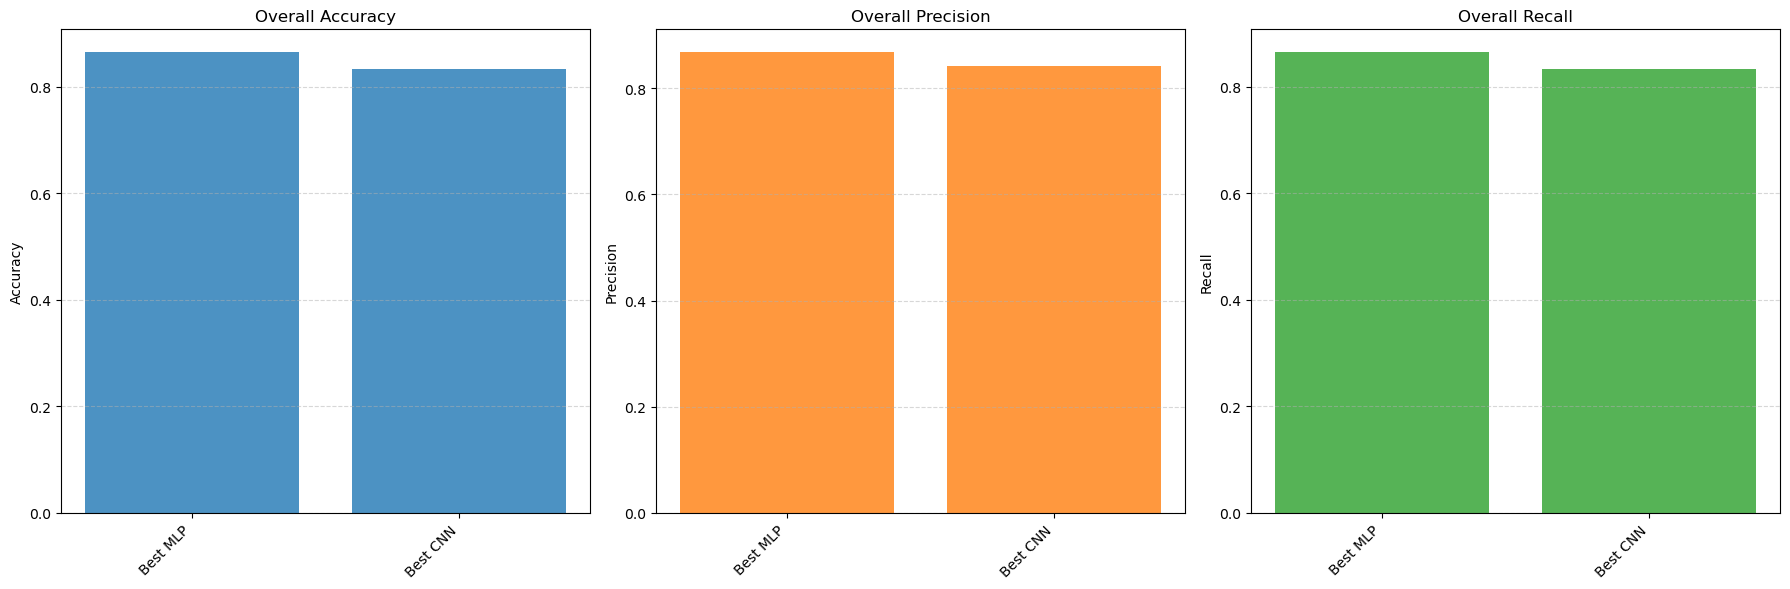

100%|██████████| 79/79 [00:03<00:00, 25.61it/s]


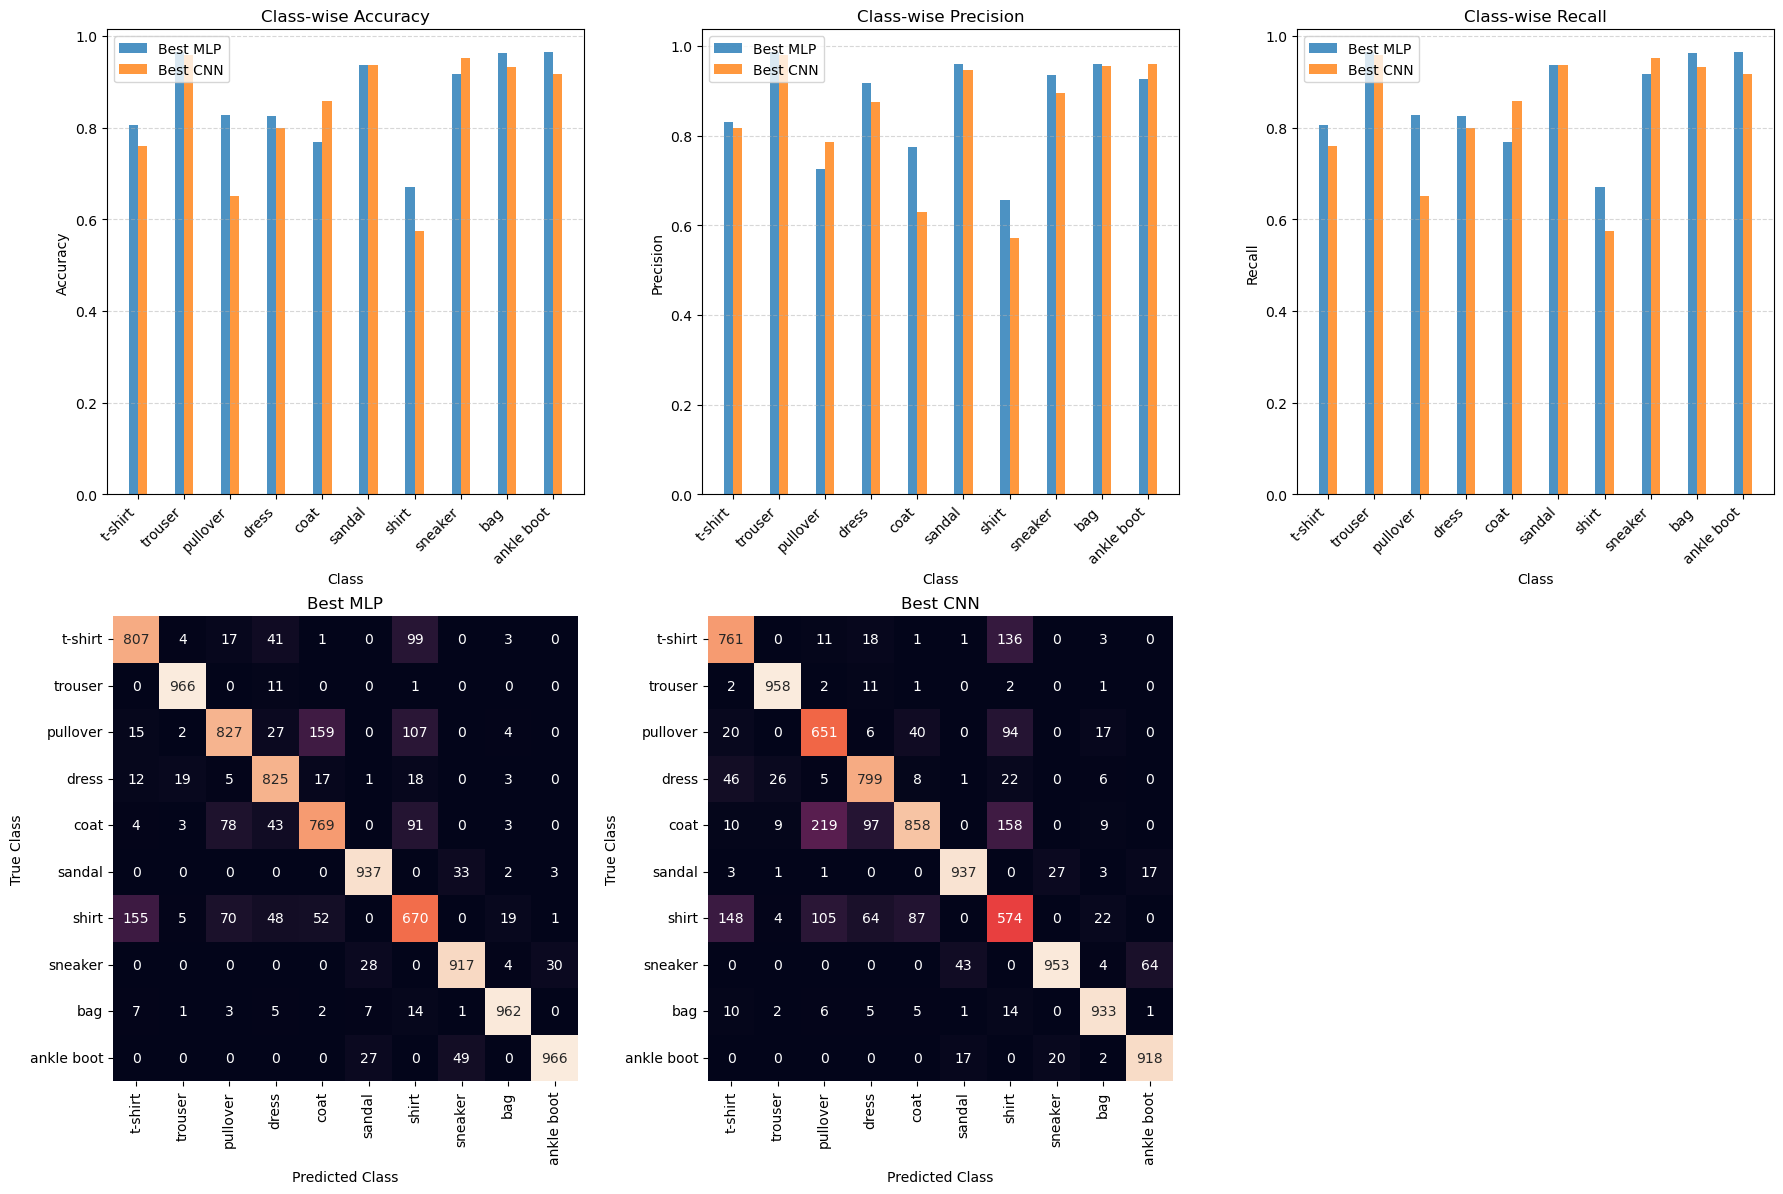

In [14]:
MLPCNN_models = {
    'Best MLP': PyTorchTrainer.load(file_lr_1e1_bs_128), # replace this with your own model
    'Best CNN': PyTorchTrainer.load(file_cnn_basic), # replace this with your own model
    }

# Visualize overall performance of MLP and CNN
evaluate_overall_metrics(MLPCNN_models)

# Visualize class-wise performance
evaluate(MLPCNN_models)


Evaluate the performance of the different architectures.

---
**Task 10 (easy): Evaluation💡**
1. Training
    - Analyze the figures and explain the key characteristics of the training process for the models.


2. Metrics
    - Assess the performance of the models by examining the confusion matrices and comparing the MLP and CNN models in terms of accuracy, precision, and recall. Discuss the strengths and weaknesses of each model based on the metrics.




---

In [0]:
# Write your reflections here...

## Modifying architectures
The next part of the exercise is about experimenting with the architecture of an NN such as _number of layers_, _number of perceptrons (nodes)_ and _kernel size_.
### MLP
The following task will add a hidden layer to the MLP model. 

---
**Task 11 (medium): Adding a hidden layer👩‍💻**
1. Locate the class `MLP_modified`
 in the `networks.py`
 file. The `MLP_modified`
 class is a copy of the `MLPBasic`
 and the following steps are about making changes in the architecture.
2. Modify the architecture by adding a new hidden layer with 256 nodes, by updating the constructor. Ensure that the number of input and output features match between the layers.
3. Update the `forward`
 function to ensure this new hidden layer is used in the predictions. 
4. Train the model by running the cell below.


---

Training MLP_Task11...
[Epoch 1]


100%|██████████| 94/94 [00:01<00:00, 48.69it/s]


[Validation] Epoch 1: acc: 0.6803, val_loss: 0.8855, train_acc: 0.5321
[Epoch 2]


100%|██████████| 94/94 [00:02<00:00, 31.85it/s]


[Validation] Epoch 2: acc: 0.7645, val_loss: 0.6555, train_acc: 0.6294
[Epoch 3]


100%|██████████| 94/94 [00:02<00:00, 46.04it/s]


[Validation] Epoch 3: acc: 0.8067, val_loss: 0.5691, train_acc: 0.6809
[Epoch 4]


100%|██████████| 94/94 [00:02<00:00, 38.55it/s]


[Validation] Epoch 4: acc: 0.8134, val_loss: 0.5292, train_acc: 0.7133
[Epoch 5]


100%|██████████| 94/94 [00:03<00:00, 25.65it/s]


[Validation] Epoch 5: acc: 0.8243, val_loss: 0.4986, train_acc: 0.7350
[Epoch 6]


100%|██████████| 94/94 [00:02<00:00, 46.95it/s]


[Validation] Epoch 6: acc: 0.8255, val_loss: 0.4959, train_acc: 0.7504
[Epoch 7]


100%|██████████| 94/94 [00:01<00:00, 48.82it/s]


[Validation] Epoch 7: acc: 0.8444, val_loss: 0.4552, train_acc: 0.7625
[Epoch 8]


100%|██████████| 94/94 [00:01<00:00, 48.94it/s]


[Validation] Epoch 8: acc: 0.8453, val_loss: 0.4483, train_acc: 0.7720
[Epoch 9]


100%|██████████| 94/94 [00:02<00:00, 45.73it/s]


[Validation] Epoch 9: acc: 0.8414, val_loss: 0.4509, train_acc: 0.7798
[Epoch 10]


100%|██████████| 94/94 [00:01<00:00, 47.93it/s]


[Validation] Epoch 10: acc: 0.8490, val_loss: 0.4326, train_acc: 0.7864


100%|██████████| 79/79 [00:01<00:00, 39.57it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x000002224B480D90>


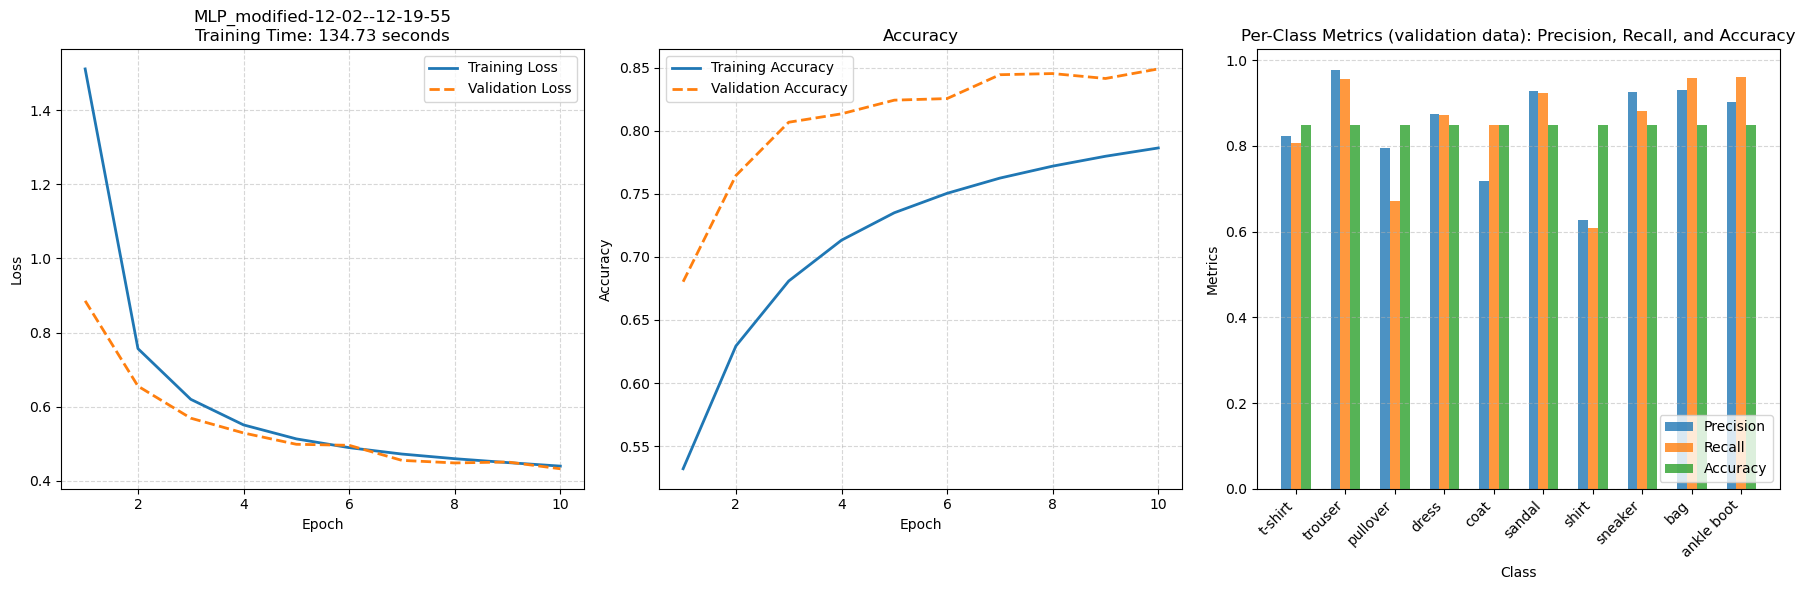

Model saved to: models\MLP_Task11_lr0p01_bs128.pkl
Training and evaluation completed. Model saved at: models/MLP_Task11_lr0p01_bs128.pkl
MLP_Task11 model saved at: models/MLP_Task11_lr0p01_bs128.pkl


In [16]:
# Train the modified MLP model with an additional hidden layer
file_mlp_task11 = train_pytorch_network_mlp(
    hidden_layers=[100, 256],      # Add the new hidden layer with 256 nodes
    activation_fn='relu',         # Default activation function
    learning_rate=1e-2,           # Same learning rate as before
    batch_size=128,               # Same batch size as before
    epochs=10,                    # Same number of epochs
    model_name="MLP_Task11"       # Custom model name for clarity
)

print(f"MLP_Task11 model saved at: {file_mlp_task11}")


---
**Task 12 (easy): Compare performance💡**
1. Examine the training figures to identify and explain the characteristics of the model’s training process. 


---

In [0]:
# Write your reflections here ...

Evaluate the modified MLP against the `MLPBasic()`


---
**Task 13 (easy): Compare architectures👩‍💻💡**
In the cell below:
1. Identify the best-performing `MLP`
 and `MLPModified`
 models based on the evaluation metrics. Update the cell below to store these selected models in the `modelsMLPModified`
 dictionary.
2. Use the `evaluate_overall_metrics`
 function to visualize the overall performance of the models.
3. Use the `evaluate`
 function to visualize the class-wise performance of the models.


---

100%|██████████| 79/79 [00:01<00:00, 53.03it/s]


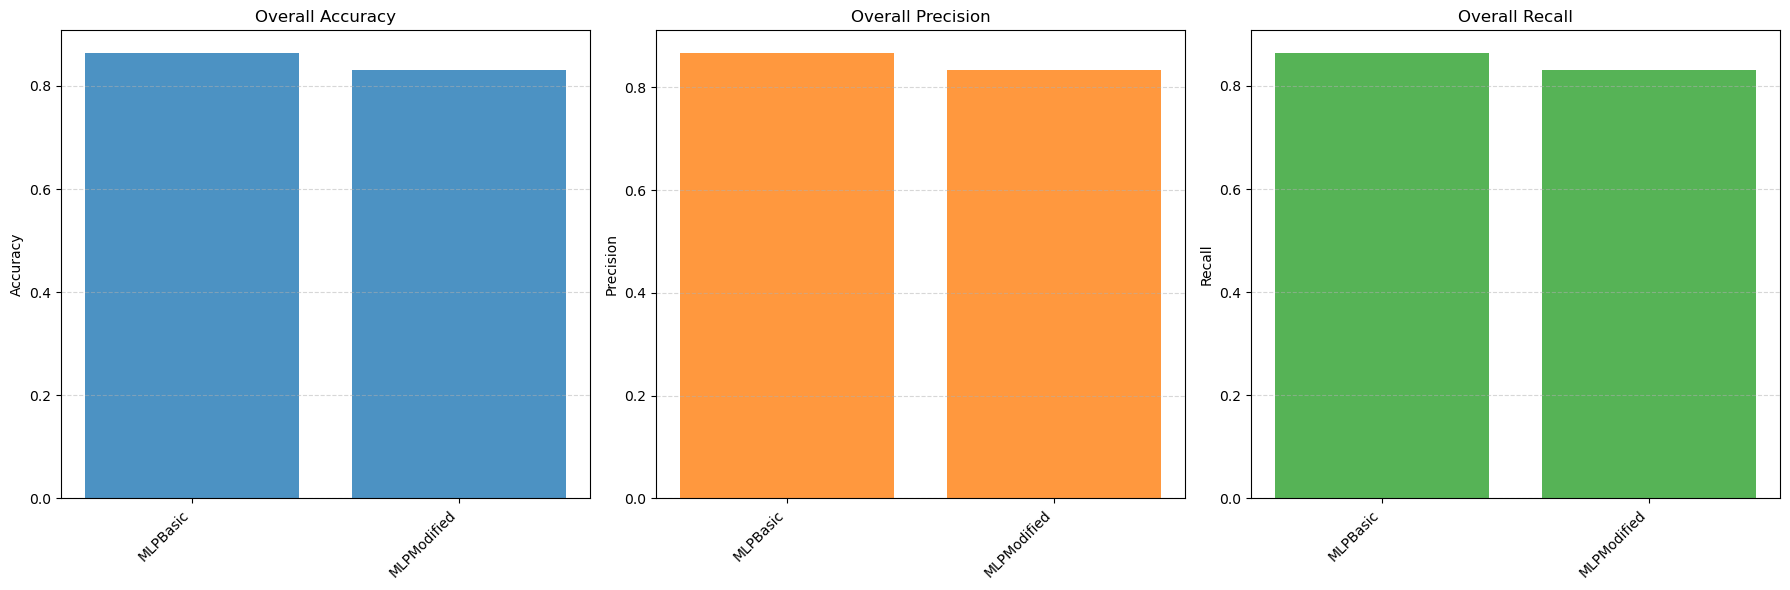

100%|██████████| 79/79 [00:02<00:00, 37.35it/s]


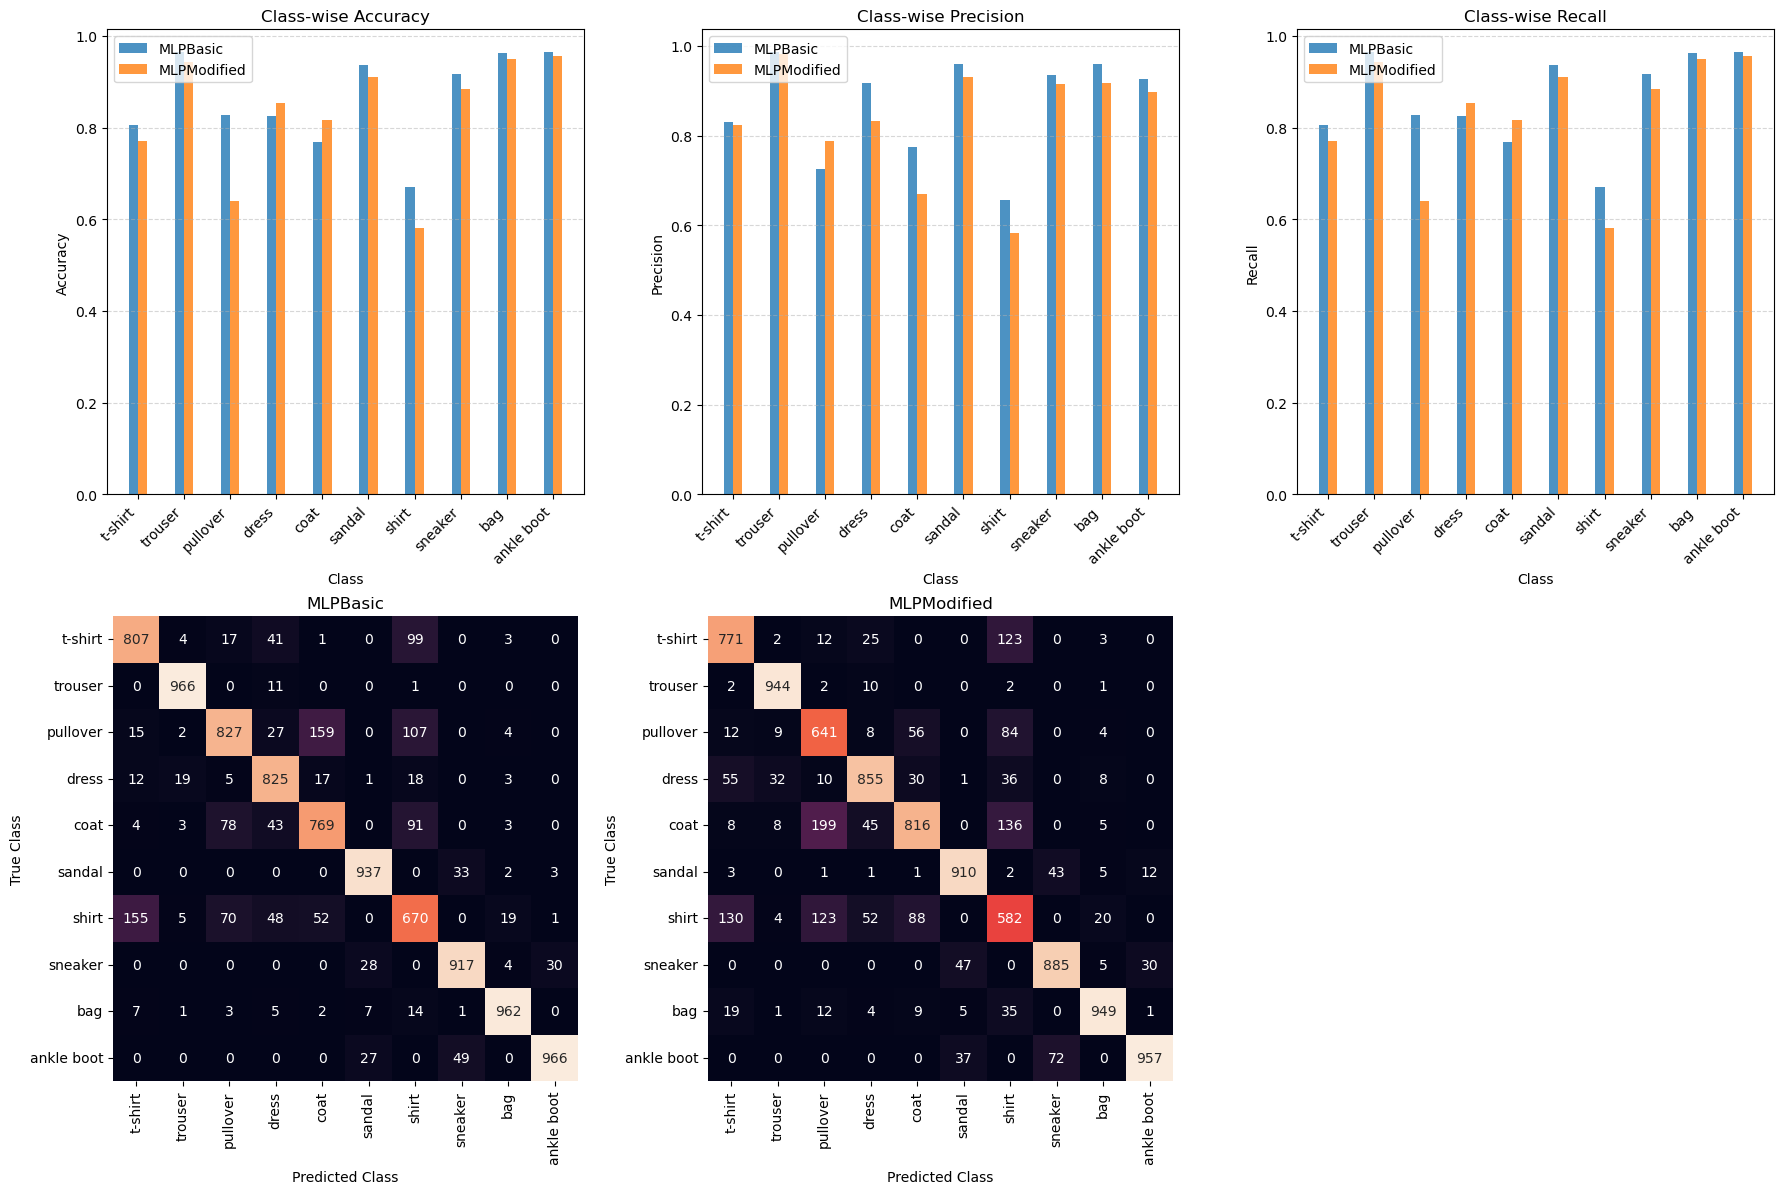

In [17]:
# Load models into a dictionary
MLPModified_model = {
    'MLPBasic': PyTorchTrainer.load(file_lr_1e1_bs_128),  # Replace with your best MLPBasic model
    'MLPModified': PyTorchTrainer.load(file_mlp_task11)  # Replace with your best MLPModified model
}

# Compare overall metrics
evaluate_overall_metrics(MLPModified_model)

# Compare class-wise metrics
evaluate(MLPModified_model)


---
**Task 14 (easy): Compare performance💡**
1. Evaluate the performance of the models by analyzing the confusion matrices. Compare the MLP and CNN models in terms of key metrics such as accuracy, precision, and recall, and provide a detailed explanation of their relative strengths and weaknesses based on these metrics


---

In [0]:
# Write your reflections here...

---
**Task 15 (easy): Update architecture👩‍💻💡**
1. Change the number of hidden nodes to 512 (adjust the other layers accordingly). 
2. Rerun the cell above to train the new model. 
3. Include the new model in the dictionary. 
4. Evaluate the model and compare it with the others as in [Task 13](#CNN_mod).

Training MLP_Task15...
[Epoch 1]


100%|██████████| 94/94 [00:03<00:00, 24.64it/s]


[Validation] Epoch 1: acc: 0.7079, val_loss: 0.8115, train_acc: 0.5854
[Epoch 2]


100%|██████████| 94/94 [00:01<00:00, 48.06it/s]


[Validation] Epoch 2: acc: 0.7831, val_loss: 0.6356, train_acc: 0.6633
[Epoch 3]


100%|██████████| 94/94 [00:01<00:00, 52.18it/s]


[Validation] Epoch 3: acc: 0.8004, val_loss: 0.5752, train_acc: 0.7057
[Epoch 4]


100%|██████████| 94/94 [00:01<00:00, 54.08it/s]


[Validation] Epoch 4: acc: 0.8255, val_loss: 0.5214, train_acc: 0.7317
[Epoch 5]


100%|██████████| 94/94 [00:01<00:00, 50.74it/s]


[Validation] Epoch 5: acc: 0.8283, val_loss: 0.4990, train_acc: 0.7500
[Epoch 6]


100%|██████████| 94/94 [00:02<00:00, 44.54it/s]


[Validation] Epoch 6: acc: 0.8356, val_loss: 0.4752, train_acc: 0.7634
[Epoch 7]


100%|██████████| 94/94 [00:02<00:00, 38.36it/s]


[Validation] Epoch 7: acc: 0.8342, val_loss: 0.4802, train_acc: 0.7738
[Epoch 8]


100%|██████████| 94/94 [00:01<00:00, 52.37it/s]


[Validation] Epoch 8: acc: 0.8410, val_loss: 0.4589, train_acc: 0.7823
[Epoch 9]


100%|██████████| 94/94 [00:03<00:00, 29.98it/s]


[Validation] Epoch 9: acc: 0.8503, val_loss: 0.4420, train_acc: 0.7892
[Epoch 10]


100%|██████████| 94/94 [00:01<00:00, 53.08it/s]


[Validation] Epoch 10: acc: 0.8508, val_loss: 0.4385, train_acc: 0.7951


100%|██████████| 79/79 [00:01<00:00, 48.39it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x0000022247C1FDF0>


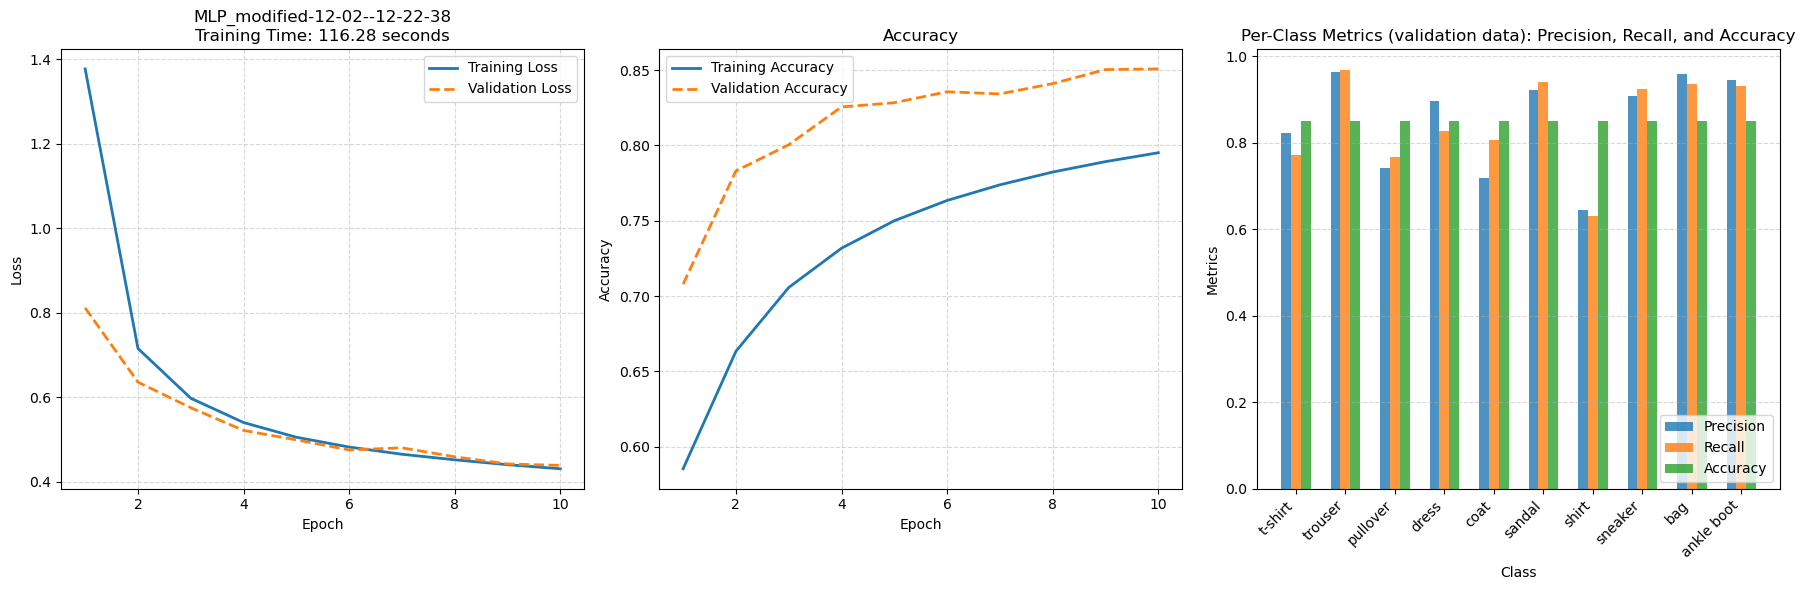

Model saved to: models\MLP_Task15_lr0p01_bs128.pkl
Training and evaluation completed. Model saved at: models/MLP_Task15_lr0p01_bs128.pkl


100%|██████████| 79/79 [00:01<00:00, 48.56it/s]


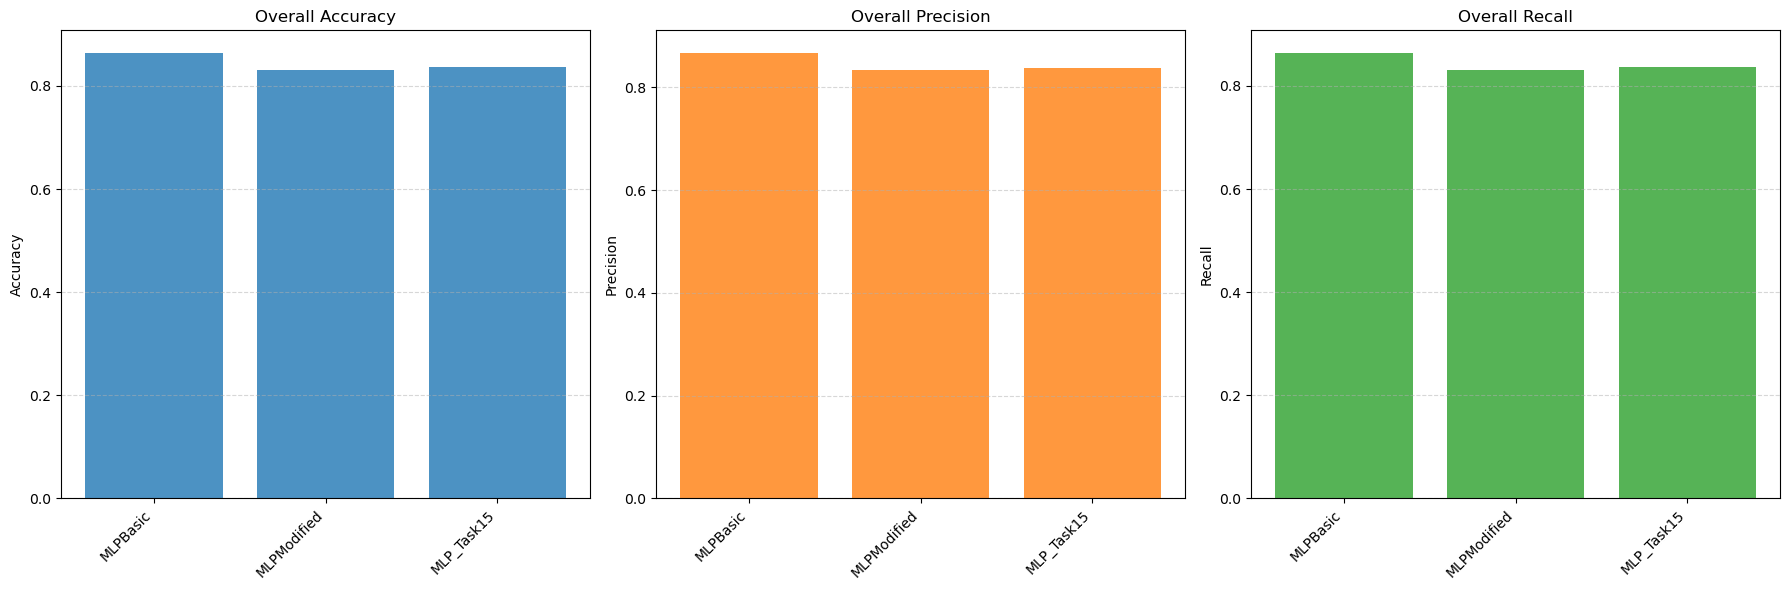

100%|██████████| 79/79 [00:01<00:00, 52.14it/s]


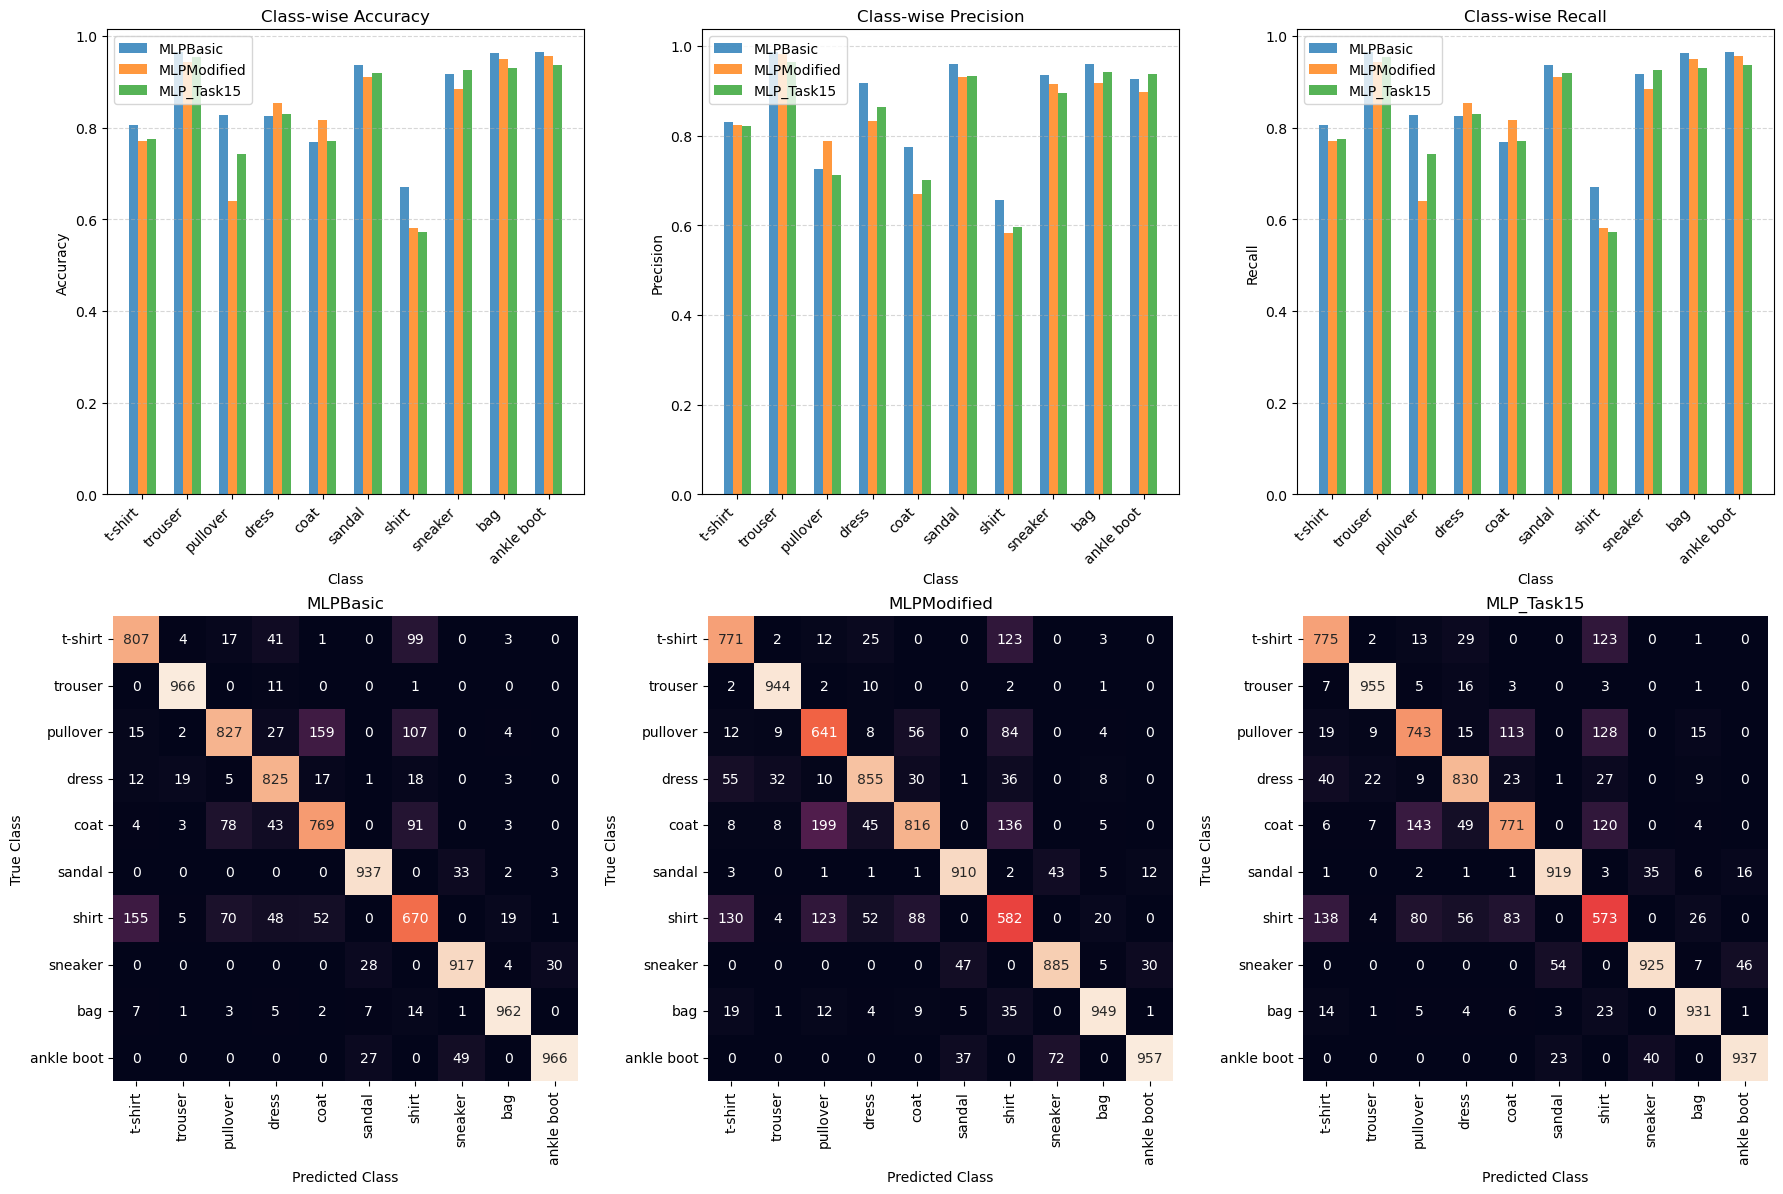

In [18]:
trainer_task_15 = train_pytorch_network_mlp(
    hidden_layers=[100, 512],
    activation_fn='relu',
    learning_rate=1e-2,
    batch_size=128,
    epochs=10,
    model_name="MLP_Task15"
)


MLPModified_model = {
    'MLPBasic': PyTorchTrainer.load(file_lr_1e1_bs_128),
    'MLPModified': PyTorchTrainer.load(file_mlp_task11),
    'MLP_Task15': PyTorchTrainer.load(trainer_task_15)
}

# Evaluate overall metrics
evaluate_overall_metrics(MLPModified_model)

# Evaluate class-wise metrics
evaluate(MLPModified_model)

## Convolutional Neural Network
The following task will involve modifying the architechture of the CNN. 

**Hint**
- Recall that the kernel size influences the size of the output image. Specifically, for kernel size $k$, the output has dimensions $w-(k-1) \times h-(k-1)$ where $w$ is the width and $h$ is the height of an image. Adding a convolutional layer is consequently a bit more tricky than a linear layer because the dimensions between the layers need to match. You will likely need to debug the model a few times to get it right, therefor we encourage you to carefully examine the structure of the network before modifying it.
- Convolutional layers MAY be accompanied with a max pooling layer, but remember to use an activation function.
- The `max_pool2d`
 operation in the`forward`
 function halves the image resolution. 



---
**Task 16 (medium): Adding a convolutional layer👩‍💻**
1. Locate the class `CNN_modified()`
 in the `networks.py`
 file.
1. Examine the class to gain an overview of the network architecture. _Note that it is a copy of the CNNBasic() class_.
2. Add a new `Conv2d`
 layer to the `CNN_modified`
 class by decreasing the kernel size of the existing first layer and add the new layer as the second layer.


**Hint**
Use `tensor.size`
 to get the size of any tensor.

4. Update the `forward`
 method to ensure this new hidden layer is used in the predictions. 
5. Train the model by running the cell below.


---

Training CNN_Task16...
[Epoch 1]


100%|██████████| 94/94 [00:03<00:00, 25.79it/s]


[Validation] Epoch 1: acc: 0.3468, val_loss: 2.2119, train_acc: 0.1990
[Epoch 2]


100%|██████████| 94/94 [00:03<00:00, 23.83it/s]


[Validation] Epoch 2: acc: 0.6389, val_loss: 0.9949, train_acc: 0.3432
[Epoch 3]


100%|██████████| 94/94 [00:03<00:00, 25.05it/s]


[Validation] Epoch 3: acc: 0.7007, val_loss: 0.8045, train_acc: 0.4486
[Epoch 4]


100%|██████████| 94/94 [00:03<00:00, 24.48it/s]


[Validation] Epoch 4: acc: 0.7229, val_loss: 0.7431, train_acc: 0.5113
[Epoch 5]


100%|██████████| 94/94 [00:03<00:00, 24.75it/s]


[Validation] Epoch 5: acc: 0.7378, val_loss: 0.7047, train_acc: 0.5534
[Epoch 6]


100%|██████████| 94/94 [00:03<00:00, 25.79it/s]


[Validation] Epoch 6: acc: 0.7431, val_loss: 0.6746, train_acc: 0.5840
[Epoch 7]


100%|██████████| 94/94 [00:03<00:00, 28.90it/s]


[Validation] Epoch 7: acc: 0.7577, val_loss: 0.6377, train_acc: 0.6074
[Epoch 8]


100%|██████████| 94/94 [00:03<00:00, 27.23it/s]


[Validation] Epoch 8: acc: 0.7626, val_loss: 0.6319, train_acc: 0.6263
[Epoch 9]


100%|██████████| 94/94 [00:03<00:00, 25.14it/s]


[Validation] Epoch 9: acc: 0.7744, val_loss: 0.5988, train_acc: 0.6418
[Epoch 10]


100%|██████████| 94/94 [00:03<00:00, 28.46it/s]


[Validation] Epoch 10: acc: 0.7816, val_loss: 0.5779, train_acc: 0.6552


100%|██████████| 79/79 [00:03<00:00, 21.39it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x000002224B7145E0>


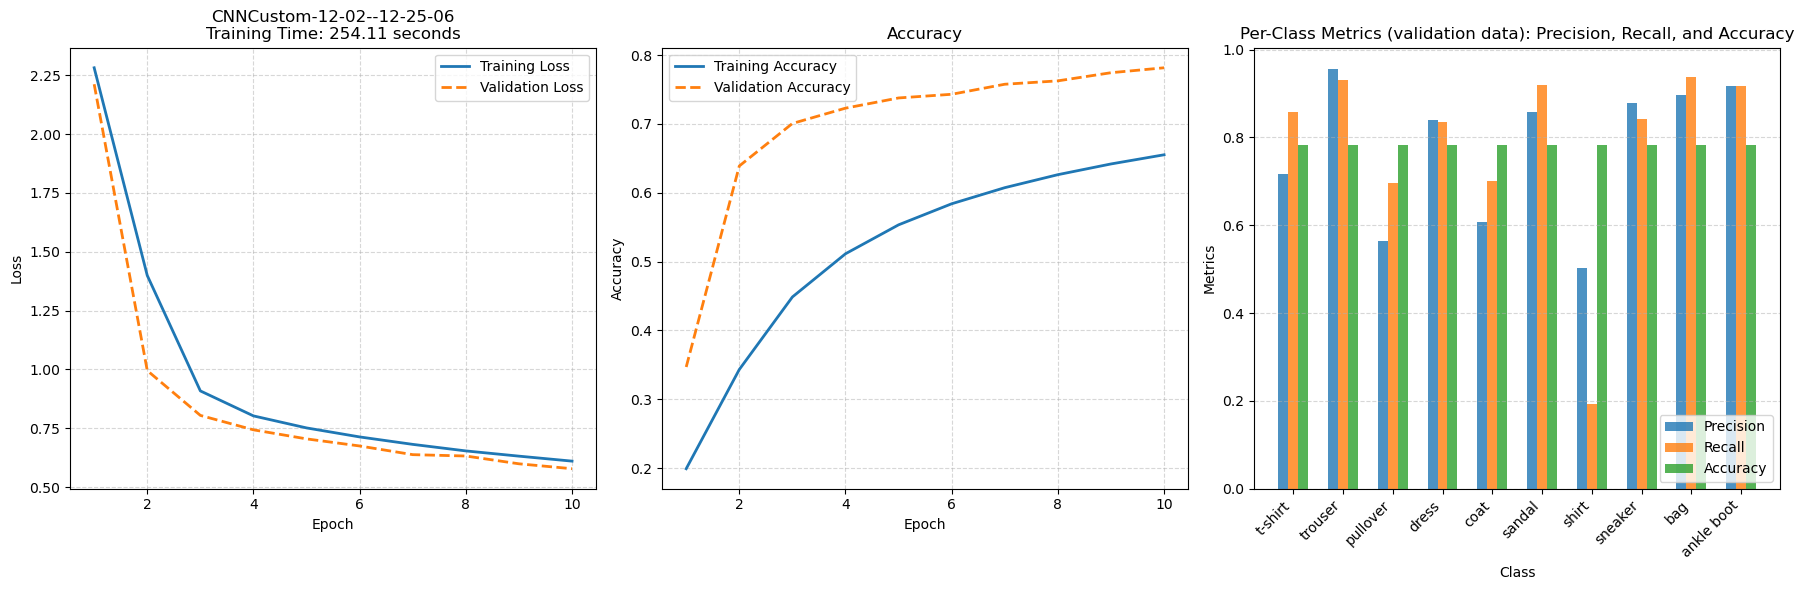

Model saved to: models\CNN_Task16_lr0p01_bs128.pkl
Training and evaluation completed. Model saved at: models/CNN_Task16_lr0p01_bs128.pkl


In [19]:
trainer_task_16 = train_pytorch_network_cnn(
    conv_layers=[(16, 5), (32, 3), (64, 3)], #3 layers. 16 kernels of size 5, 32 kernels of size 3, 64 kernels of size 3
    fc_layers=[128, 10], # 2 layers. 128 nodes in the hidden layer, 10 nodes in the output layer
    activation_fn='relu',
    learning_rate=1e-2,
    batch_size=128,
    epochs=10,
    model_name="CNN_Task16"
)



---
**Task 17 (easy): Compare architectures👩‍💻💡**
1. Fill in the dictionary below with the best performing `CNNBasic()`
 model and the `CNNModified()`
.
2. Visualize the overall performance by running `evaluate_overall_metrics`
 function.
3. Visualize the class-wise performance by running the `evaluate`
 function.


---

100%|██████████| 79/79 [00:02<00:00, 27.24it/s]


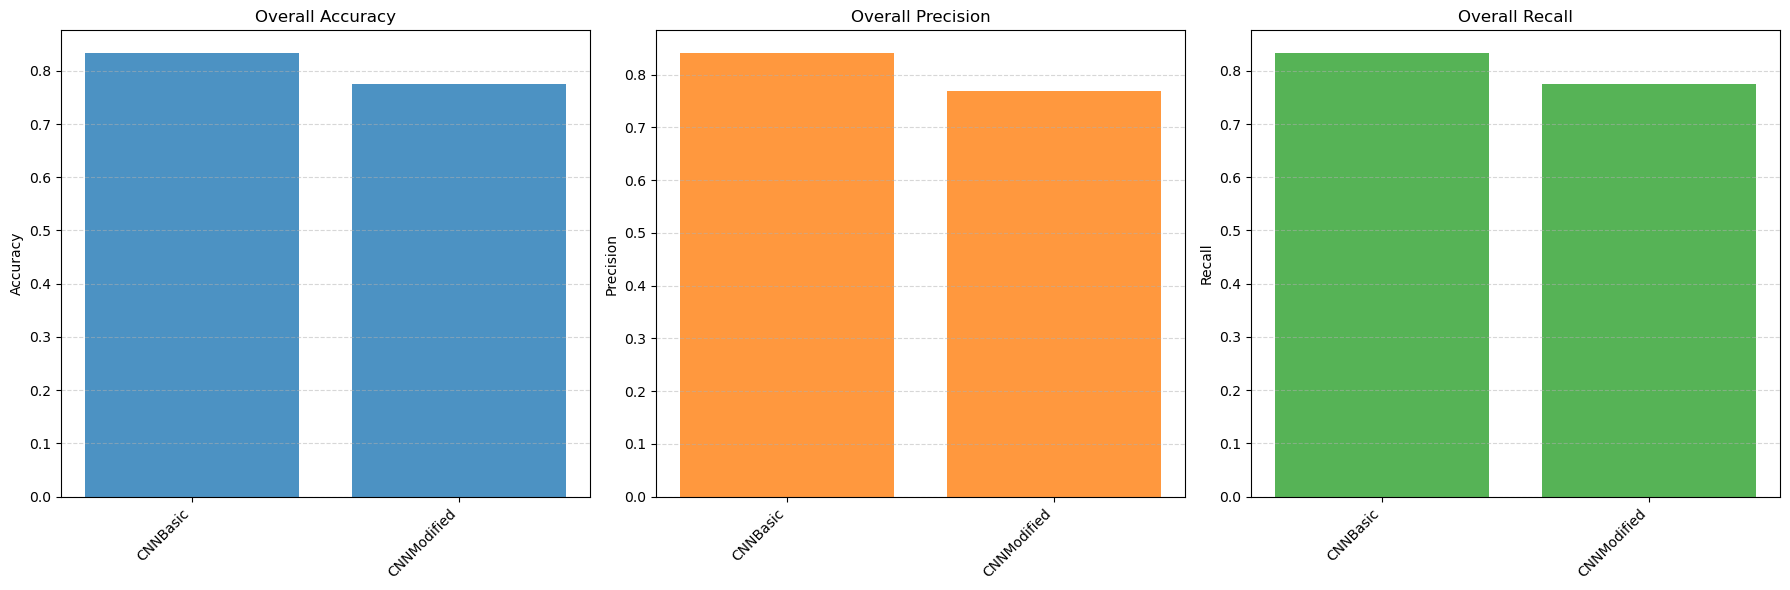

100%|██████████| 79/79 [00:02<00:00, 30.15it/s]


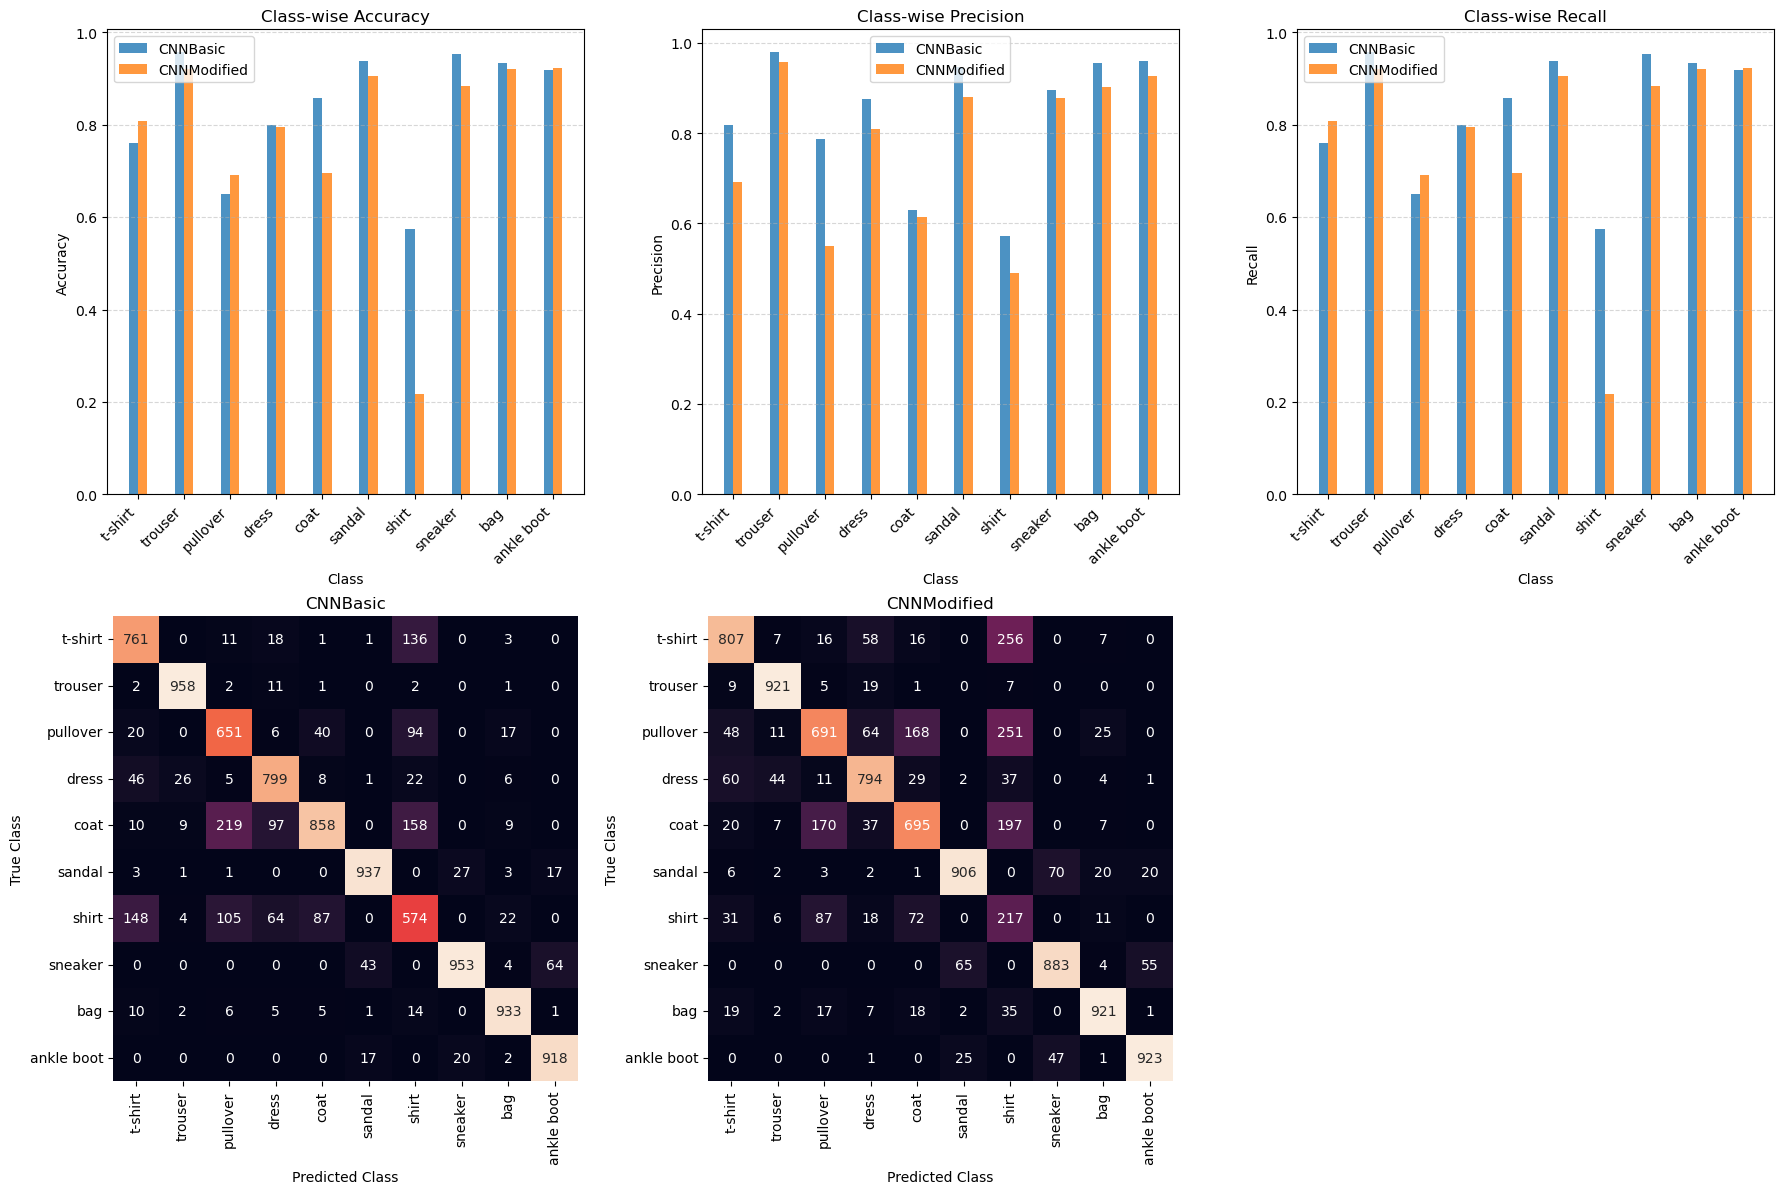

In [20]:
# Load the best-performing models
CNNModified_model = {
    'CNNBasic': PyTorchTrainer.load(file_cnn_basic),  # Replace with your best CNNBasic model
    'CNNModified': PyTorchTrainer.load(trainer_task_16)  # Replace with your best CNNModified model
}

# Compare overall metrics
evaluate_overall_metrics(CNNModified_model)

# Compare class-wise metrics
evaluate(CNNModified_model)


---
**Task 18 (medium): Compare architectures💡**
Evaluate the modified CNN against the `CNNBasic()`
 following the steps: 
1. During training:
    - Include the trained `CNNBasic()`
and the `CNNModified()`
 in the graphs (leave out the rest).
    - What patterns or trends do you observe in the loss and accuracy graphs and training time throughout training?


2. Update the dictionary below with the trained models and execute the cell. Compare the performance of the models, providing an analysis and explanation of the observed differences.

3. Change the kernel size and the number of kernels to achieve the best performing model, while avoiding overfitting. Run the cell above to train the new model. Include the new model in the dictionary, evaluate the model and compare it with the others.



---

Skipping training for CNN_TwoLayers_SmallAndFewKernels. Returning filename: models/CNN_TwoLayers_SmallAndFewKernels_lr0p01_bs128.pkl
Skipping training for CNN_TwoLayers_SmallKernels. Returning filename: models/CNN_TwoLayers_SmallKernels_lr0p01_bs128.pkl
Skipping training for CNN_TwoLayers_MediumKernels. Returning filename: models/CNN_TwoLayers_MediumKernels_lr0p01_bs128.pkl
Skipping training for CNN_TwoLayers_LargeInitial. Returning filename: models/CNN_TwoLayers_LargeInitial_lr0p01_bs128.pkl
Skipping training for CNN_ThreeLayers_DecreasingKernels. Returning filename: models/CNN_ThreeLayers_DecreasingKernels_lr0p01_bs128.pkl
Skipping training for CNN_ThreeLayers_UniformSmallKernels. Returning filename: models/CNN_ThreeLayers_UniformSmallKernels_lr0p01_bs128.pkl
Skipping training for CNN_ThreeLayers_LargeKernels. Returning filename: models/CNN_ThreeLayers_LargeKernels_lr0p01_bs128.pkl


100%|██████████| 79/79 [00:05<00:00, 14.93it/s]


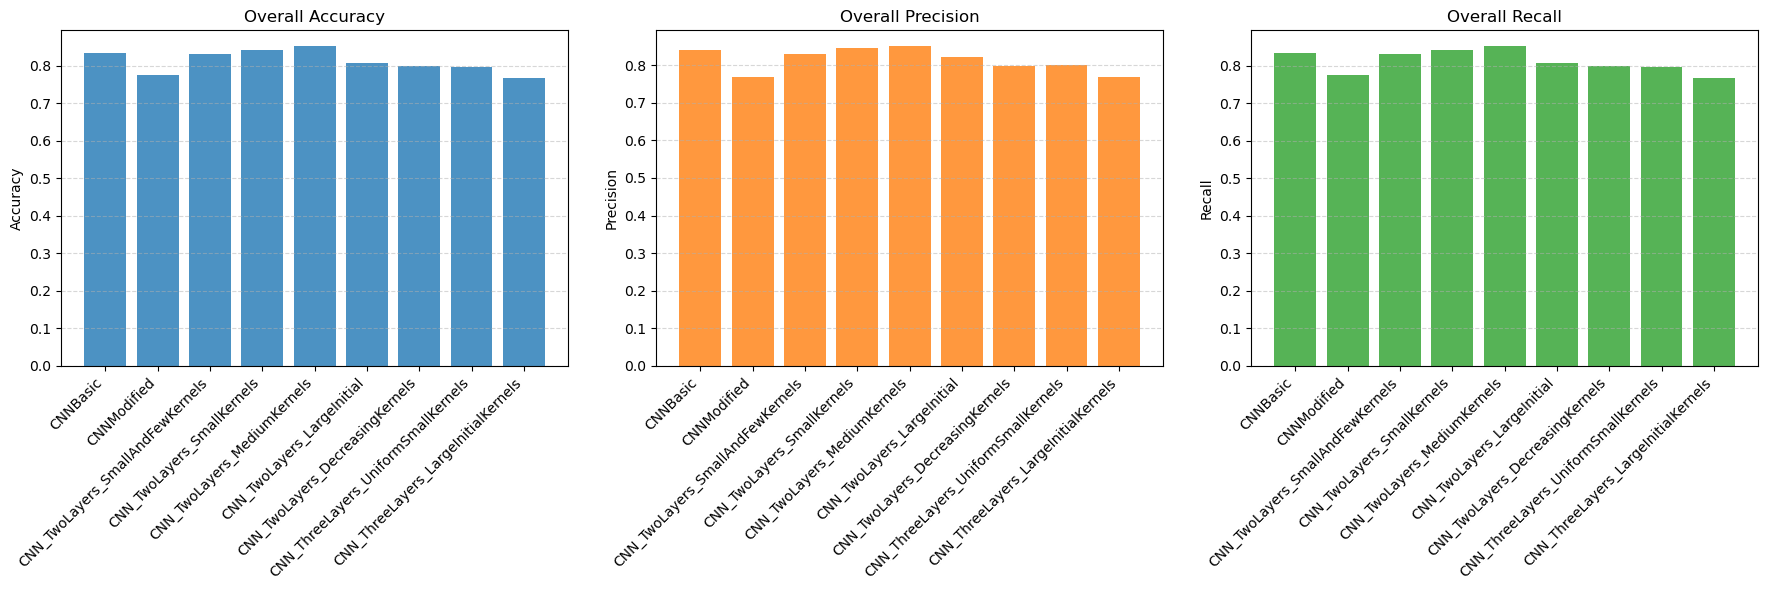

100%|██████████| 79/79 [00:07<00:00,  9.94it/s]


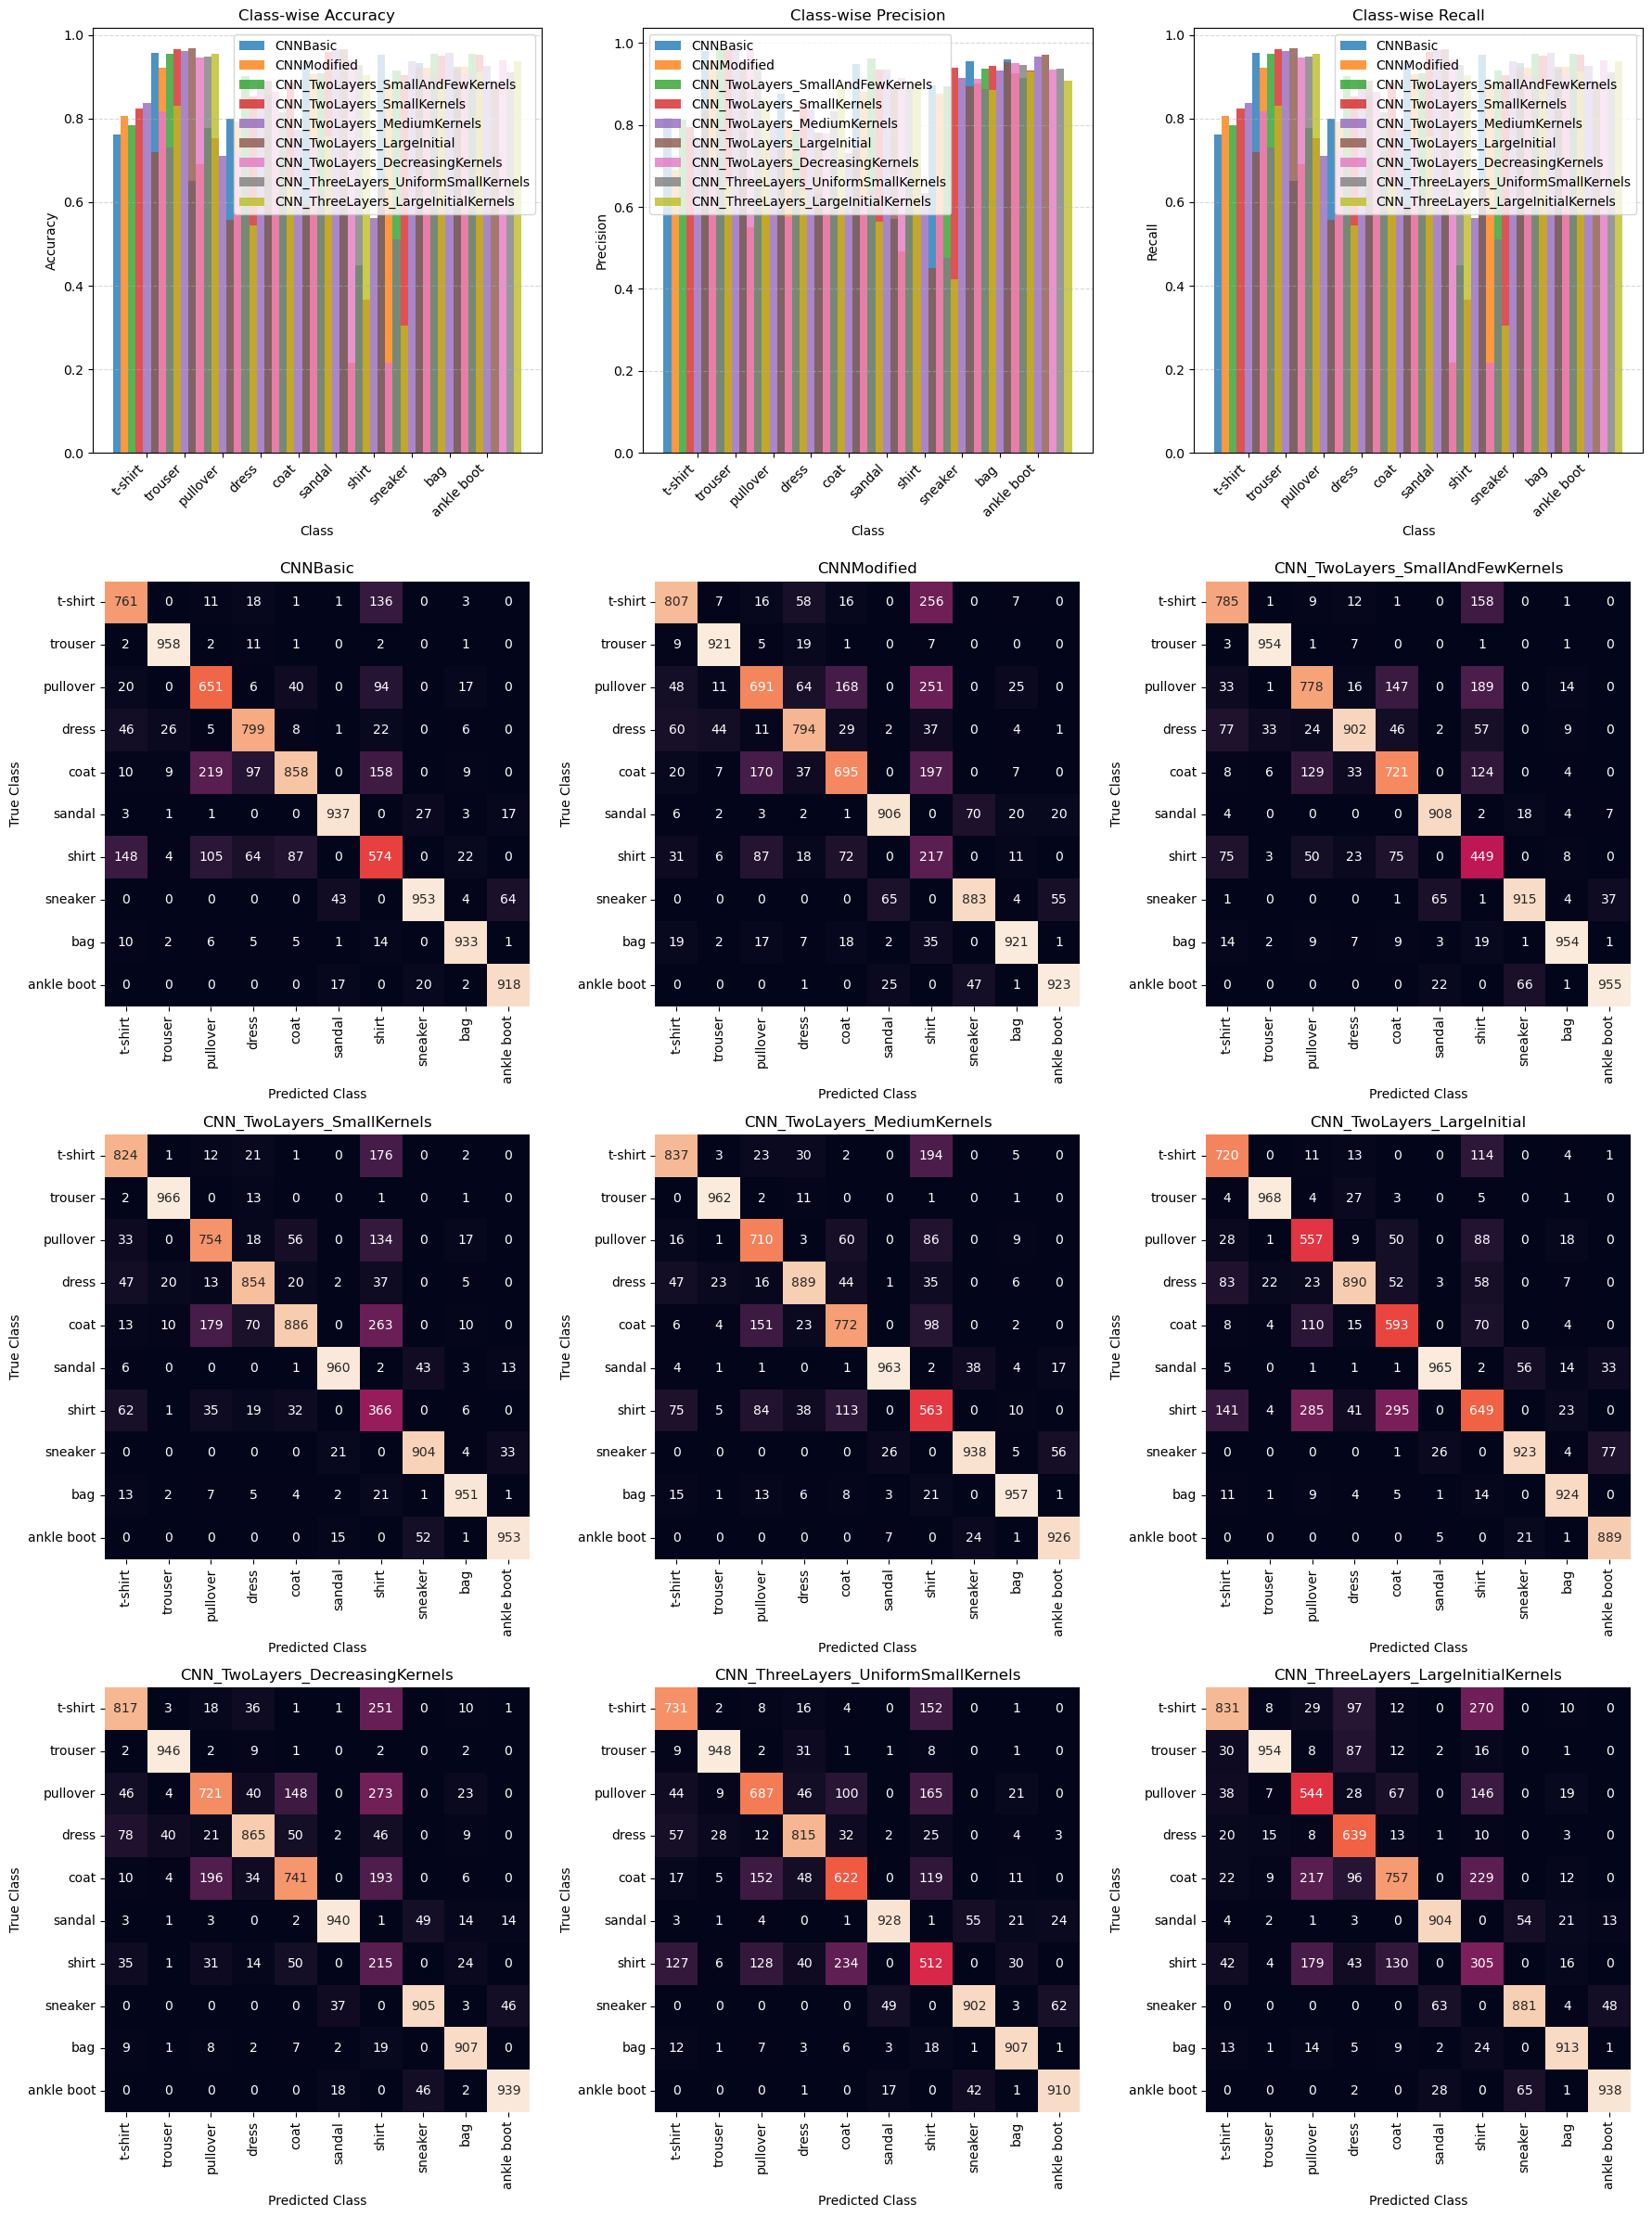

In [32]:
SKIP_TRAINING = True

# Two convolutional layers with small kernels and few kernels
trainer_two_layers_Small_And_Few_kernels = train_pytorch_network_cnn(
    conv_layers=[(8, 3), (16, 3)],  # Small kernel sizes
    fc_layers=[256, 10],            # Fully connected layers
    activation_fn='relu',
    learning_rate=1e-2,
    batch_size=128,
    epochs=10,
    model_name="CNN_TwoLayers_SmallAndFewKernels"
)

# Two convolutional layers with small kernels
trainer_two_layers_Small_kernels = train_pytorch_network_cnn(
    conv_layers=[(32, 3), (64, 3)],  # Small kernel sizes
    fc_layers=[256, 10],            # Fully connected layers
    activation_fn='relu',
    learning_rate=1e-2,
    batch_size=128,
    epochs=10,
    model_name="CNN_TwoLayers_SmallKernels"
)

# Two convolutional layers with medium kernels
trainer_two_layers_medium_kernels = train_pytorch_network_cnn(
    conv_layers=[(32, 5), (64, 5)],  # Medium kernel sizes
    fc_layers=[256, 10],            # Fully connected layers
    activation_fn='relu',
    learning_rate=1e-2,
    batch_size=128,
    epochs=10,
    model_name="CNN_TwoLayers_MediumKernels"
)

# Two convolutional layers with larger initial kernel
trainer_two_layers_large_initial = train_pytorch_network_cnn(
    conv_layers=[(32, 7), (64, 5)],  # Larger kernel in the first layer
    fc_layers=[256, 10],
    activation_fn='relu',
    learning_rate=1e-2,
    batch_size=128,
    epochs=10,
    model_name="CNN_TwoLayers_LargeInitial"
)


# Three convolutional layers with decreasing kernel sizes
trainer_two_layers_decreasing_kernels = train_pytorch_network_cnn(
    conv_layers=[(16, 7), (32, 3)],  # Larger initial kernel decreasing in later layers
    fc_layers=[256, 10],
    activation_fn='relu',
    learning_rate=1e-2,
    batch_size=128,
    epochs=10,
    model_name="CNN_ThreeLayers_DecreasingKernels"
)


# Three convolutional layers with uniform small kernels
trainer_three_layers_uniform_small_kernels = train_pytorch_network_cnn(
    conv_layers=[(32, 3), (64, 3), (128, 3)],  # Uniform small kernels
    fc_layers=[256, 10],
    activation_fn='relu',
    learning_rate=1e-2,
    batch_size=128,
    epochs=10,
    model_name="CNN_ThreeLayers_UniformSmallKernels"
)

# Three convolutional layers with larger kernels
trainer_three_layers_large_kernels = train_pytorch_network_cnn(
    conv_layers=[(32, 5), (64, 3), (128, 3)],  # Large kernels in all layers
    fc_layers=[512, 256, 10],
    activation_fn='relu',
    learning_rate=1e-2,
    batch_size=128,
    epochs=10,
    model_name="CNN_ThreeLayers_LargeKernels"
)

# Load trained models
CNNKernelExperiments = {
    'CNNBasic': PyTorchTrainer.load(file_cnn_basic),
    'CNNModified': PyTorchTrainer.load(trainer_task_16),
    'CNN_TwoLayers_SmallAndFewKernels': PyTorchTrainer.load(trainer_two_layers_Small_And_Few_kernels),
    'CNN_TwoLayers_SmallKernels': PyTorchTrainer.load(trainer_two_layers_Small_kernels),
    'CNN_TwoLayers_MediumKernels': PyTorchTrainer.load(trainer_two_layers_medium_kernels),
    'CNN_TwoLayers_LargeInitial': PyTorchTrainer.load(trainer_two_layers_large_initial),
    'CNN_TwoLayers_DecreasingKernels': PyTorchTrainer.load(trainer_two_layers_decreasing_kernels),
    'CNN_ThreeLayers_UniformSmallKernels': PyTorchTrainer.load(trainer_three_layers_uniform_small_kernels),
    'CNN_ThreeLayers_LargeInitialKernels': PyTorchTrainer.load(trainer_three_layers_large_kernels)
}

# Compare overall metrics
evaluate_overall_metrics(CNNKernelExperiments)

# Compare class-wise metrics
evaluate(CNNKernelExperiments)


## Task 18 reflections

Why decreasing kernel size: Starts with large features, narrowing as depth increases.

This exercise has briefly introduced some modifications that can improve the performance of a model. While this was just a brief introduction many more alterations can be performed. However, as noted, this easily becomes a time sink. The next task is optional and continues the introduction of possible alterations.

---
**Task 19 (hard): Additional improvements _(optional)_👩‍💻**
Change the activation functions, the number of hidden layers, and the training setup to achieve the best performing model. Notice, that a huge amount of time can be spent on fiddling with the models.

---

In [ ]:
# Train the improved CNN with three convolutional layers and advanced configurations
file_cnn_task19 = train_pytorch_network_cnn(
    input_channels=1,                   # Grayscale images
    conv_layers=[(32, 5), (64, 3), (128, 3)],  # Three convolutional layers
    fc_layers=[256, 128, 10],           # Fully connected layers
    activation_fn='leaky_relu',         # Use leaky_relu activation
    learning_rate=1e-3,                 # Smaller learning rate for Adam
    batch_size=64,                      # Smaller batch size
    epochs=20,                          # Train for 20 epochs
    optimizer_type='adam',              # Use Adam optimizer
    lr_scheduler='plateau',             # Use ReduceLROnPlateau scheduler
    model_name="CNN_Task19"             # Custom model name
)

print(f"Improved CNN model saved at: {file_cnn_task19}")


# Train the improved MLP with three hidden layers and advanced configurations
file_mlp_task19 = train_pytorch_network_mlp(
    hidden_layers=[128, 256, 128],      # Three hidden layers with varying sizes
    activation_fn='leaky_relu',         # Use leaky_relu activation
    learning_rate=1e-3,                 # Smaller learning rate for Adam
    batch_size=64,                      # Smaller batch size
    epochs=20,                          # Train for 20 epochs
    optimizer_type='adam',              # Use Adam optimizer
    lr_scheduler='plateau',             # Use ReduceLROnPlateau scheduler
    model_name="MLP_Task19"             # Custom model name
)

print(f"Improved MLP model saved at: {file_mlp_task19}")

# Load the trained models into a dictionary
CNNImproved_model = {
    'CNNBasic': PyTorchTrainer.load('models/CNNBasic_lr0p01_bs128.pkl'),      # Pretrained CNNBasic model
    'CNNModified': PyTorchTrainer.load('models/CNNModified_lr0p01_bs128.pkl'), # Pretrained CNNModified model
    'CNNImproved': PyTorchTrainer.load(file_cnn_task19),                       # Improved CNN model
    'MLPImproved': PyTorchTrainer.load(file_mlp_task19)                        # Improved MLP model
}

# Compare overall metrics
evaluate_overall_metrics(CNNImproved_model)

# Compare class-wise metrics
evaluate(CNNImproved_model)